## Setting

In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter("ignore", category=FutureWarning)

In [3]:
# Import standard python libraries
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os, subprocess

In [2]:
from coolpuppy import coolpup
from coolpuppy.lib import numutils
from coolpuppy.lib.puputils import divide_pups
from coolpuppy import plotpup
import cooler
import bioframe
import cooltools
from cooltools import expected_cis, expected_trans
from cooltools.lib import plotting

# Functions for generalization

In [8]:
import copy

def callAPAoverLoop(coolFileDir, coolFileName, loopFileDir, loopFileName, minDiag, byDistance, balance, ooe):
    # minDist = minimun distance in kb to plot in APA
    # Load cool file
    cool_file = coolFileDir + '/' + coolFileName + '_KR.cool'
    clr = cooler.Cooler(f'{cool_file}')
    # Load loop file
    loop_file = loopFileDir + '/' + loopFileName + '.bedpe'
    loop = pd.read_csv(loop_file, sep = '\t', header = None).iloc[:, :6]
    loop.columns = ['chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2']
    # Load expected table
    exp_file = coolFileDir + '/' + coolFileName + '_KR_exp.tsv'
    exp_df = pd.read_csv(exp_file, delimiter='\t')

    # keep loop count
    nloops = len(loop)
    
    # Pileup
    if ooe:
        pup = coolpup.pileup(clr, loop, features_format = 'bedpe',
                             min_diag = minDiag, by_distance = byDistance,
                             nproc = 12, 
                             clr_weight_name = balance,
                             ooe = True, expected_df = exp_df)
    else:
         pup = coolpup.pileup(clr, loop, features_format = 'bedpe',
                             min_diag = minDiag, by_distance = byDistance,
                             nproc = 12, 
                             clr_weight_name = balance,
                             ooe = False)       
    return pup, nloops

def get_corner_score(pup, flank = 1):
    amap = pup["data"][0]
    c = amap.shape[0] / (flank*2 + 1)
    c = int(c)
    central = np.nanmean(amap[flank*c:-flank:c, flank*c:-flank*c])
    topRight = np.nanmean(amap[:c, -c:])
    cornerScore = central/topRight
    return cornerScore, central, topRight


def drawAPA(pup, nloops, scale, colormap, vmax, vmin, fileDir, fileName):
    puptemp = copy.deepcopy(pup)
    if scale == 'log10':
        puptemp.data[0] = np.log10(puptemp.data[0])
    # Make figure
    # Enrichment score is calculated by ratio of C(obs/exp) to R (obs/exp) before doing any form of log transform
    corner = str(round(get_corner_score(pup, flank = 2)[0], 2))
    
    if vmax == False:
        fg1 = plotpup.plot(puptemp,
                           cmap = colormap,
                           score = False, 
                           scale = 'linear', height = 1, plot_ticks = True, font_scale = 0.8)

        ax = fg1.ax

        ax.text(
            0.95, 0.95,                   # 95% from left, 95% from bottom
            f"corner score: {corner}",
            va="top", ha="right",
            transform=ax.transAxes,       # ← important!
            size=4
        )

        ax.text(
            0.95, 0.85,
            f"n loops: {nloops}",
            va="top", ha="right",
            transform=ax.transAxes,
            size=4
        )

    else:
        fg1 = plotpup.plot(puptemp,
                   cmap = colormap,
                   score = False, vmax = vmax, vmin = vmin,
                   scale = 'linear', height = 1, plot_ticks = True, font_scale = 0.8)
        ax = fg1.ax
        ax.text(
            0.95, 0.95,                   # 95% from left, 95% from bottom
            f"corner score: {corner}",
            va="top", ha="right",
            transform=ax.transAxes,       # ← important!
            size=4
        )
        ax.text(
            0.95, 0.85,
            f"n loops: {nloops}",
            va="top", ha="right",
            transform=ax.transAxes,
            size=4
        )
    file = fileDir + '/' + fileName + '.svg'
    fg1.savefig(file, format = 'svg')
    return True


# APA plot

In [5]:
# LOADING COOL FILE
coolDir = '/Volumes/UKJIN_SSD/data/cool_norm_pooled'
figDir = '/Volumes/UKJIN_SSD/figure/loop_hicdcp'
loopDir = '/Volumes/UKJIN_SSD/data/loop_hicdcp'

os.makedirs(figDir, exist_ok=True)


In [ ]:
cutoffs = [0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0]

for res in ['10000']:
    for sample in ['G1dTAG_pooled', 'G1A485_pooled']:
        for i in range(len(cutoffs) - 1):
            upper = cutoffs[i]
            lower = cutoffs[i + 1]
            tag   = f"{upper}_{lower}"
            bedpe = f"testing_{sample}_10kb_hicdcplus_qval{tag}"
            try:
x                pup, nloops = callAPAoverLoop(coolDir, sample + '_' + str(res) + 'bp',
                        loopDir, bedpe,
                        minDiag = 2, byDistance = False,
                        balance = 'weight', ooe = True)
                fileName = 'APA_' + sample + '_hicdcp_10kb_qval' + tag
                drawAPA(pup, nloops, scale = 'log10', colormap = 'coolwarm', vmax = False, vmin = False,
                        fileDir = figDir, fileName = fileName)
                # drawAPA(pup, nloops, scale = 'log10', colormap = 'coolwarm', vmax = 1, vmin = 0,
                #           fileDir = figDir, fileName = fileName + '_minmax')
            except:
                print(f"Failed to process {sample} at resolution {res} with cutoff {tag}")
                continue

flag1


INFO:coolpuppy:('chr12', 'chr12'): 4649
INFO:coolpuppy:('chr10', 'chr10'): 5514
INFO:coolpuppy:('chr8', 'chr8'): 4487
INFO:coolpuppy:('chr4', 'chr4'): 3930
INFO:coolpuppy:('chr9', 'chr9'): 6717
INFO:coolpuppy:('chr6', 'chr6'): 5250
INFO:coolpuppy:('chr3', 'chr3'): 7079
INFO:coolpuppy:('chr7', 'chr7'): 1642
INFO:coolpuppy:('chr5', 'chr5'): 5045
INFO:coolpuppy:('chr19', 'chr19'): 2561
INFO:coolpuppy:('chr11', 'chr11'): 9463
INFO:coolpuppy:('chr17', 'chr17'): 2310
INFO:coolpuppy:('chr16', 'chr16'): 5232
INFO:coolpuppy:('chr2', 'chr2'): 9851
INFO:coolpuppy:('chr18', 'chr18'): 3765
INFO:coolpuppy:('chr13', 'chr13'): 5565
INFO:coolpuppy:('chrX', 'chrX'): 884
INFO:coolpuppy:('chr14', 'chr14'): 2359
INFO:coolpuppy:('chr15', 'chr15'): 5170
INFO:coolpuppy:('chr1', 'chr1'): 11148
INFO:coolpuppy:Total number of piled up windows: 102621
INFO:coolpuppy:Can't use symmetrical scale with linear. Plotting non-symmetrical


flag2
flag3
flag1


INFO:coolpuppy:('chr12', 'chr12'): 179
INFO:coolpuppy:('chr9', 'chr9'): 256
INFO:coolpuppy:('chr8', 'chr8'): 198
INFO:coolpuppy:('chr7', 'chr7'): 328
INFO:coolpuppy:('chr13', 'chr13'): 834
INFO:coolpuppy:('chr4', 'chr4'): 259
INFO:coolpuppy:('chr3', 'chr3'): 600
INFO:coolpuppy:('chr5', 'chr5'): 133
INFO:coolpuppy:('chr6', 'chr6'): 196
INFO:coolpuppy:('chr10', 'chr10'): 307
INFO:coolpuppy:('chr16', 'chr16'): 150
INFO:coolpuppy:('chr17', 'chr17'): 86
INFO:coolpuppy:('chr19', 'chr19'): 67
INFO:coolpuppy:('chr15', 'chr15'): 141
INFO:coolpuppy:('chr14', 'chr14'): 97
INFO:coolpuppy:('chrX', 'chrX'): 318
INFO:coolpuppy:('chr18', 'chr18'): 100
INFO:coolpuppy:('chr11', 'chr11'): 474
INFO:coolpuppy:('chr2', 'chr2'): 349
INFO:coolpuppy:('chr1', 'chr1'): 327
INFO:coolpuppy:Total number of piled up windows: 5399
INFO:coolpuppy:Can't use symmetrical scale with linear. Plotting non-symmetrical


flag2
flag3
flag1


INFO:coolpuppy:('chr12', 'chr12'): 2441
INFO:coolpuppy:('chr8', 'chr8'): 1974
INFO:coolpuppy:('chr9', 'chr9'): 4208
INFO:coolpuppy:('chr10', 'chr10'): 3179
INFO:coolpuppy:('chr7', 'chr7'): 1143
INFO:coolpuppy:('chr14', 'chr14'): 1181
INFO:coolpuppy:('chr3', 'chr3'): 4509
INFO:coolpuppy:('chr11', 'chr11'): 4457
INFO:coolpuppy:('chr15', 'chr15'): 2540
INFO:coolpuppy:('chr13', 'chr13'): 3262
INFO:coolpuppy:('chr5', 'chr5'): 2508
INFO:coolpuppy:('chr4', 'chr4'): 1854
INFO:coolpuppy:('chr17', 'chr17'): 938
INFO:coolpuppy:('chr6', 'chr6'): 3263
INFO:coolpuppy:('chr18', 'chr18'): 2354
INFO:coolpuppy:('chr16', 'chr16'): 2925
INFO:coolpuppy:('chr19', 'chr19'): 1212
INFO:coolpuppy:('chrX', 'chrX'): 1079
INFO:coolpuppy:('chr1', 'chr1'): 6140
INFO:coolpuppy:('chr2', 'chr2'): 4830
INFO:coolpuppy:Total number of piled up windows: 55997
INFO:coolpuppy:Can't use symmetrical scale with linear. Plotting non-symmetrical


flag2
flag3
flag1


INFO:coolpuppy:('chr12', 'chr12'): 1379
INFO:coolpuppy:('chr7', 'chr7'): 976
INFO:coolpuppy:('chr8', 'chr8'): 1225
INFO:coolpuppy:('chr10', 'chr10'): 2032
INFO:coolpuppy:('chr9', 'chr9'): 1867
INFO:coolpuppy:('chr5', 'chr5'): 1516
INFO:coolpuppy:('chr4', 'chr4'): 1225
INFO:coolpuppy:('chr13', 'chr13'): 1950
INFO:coolpuppy:('chr3', 'chr3'): 2190
INFO:coolpuppy:('chr6', 'chr6'): 1854
INFO:coolpuppy:('chr11', 'chr11'): 3092
INFO:coolpuppy:('chr14', 'chr14'): 864
INFO:coolpuppy:('chr15', 'chr15'): 1555
INFO:coolpuppy:('chr16', 'chr16'): 1343
INFO:coolpuppy:('chr17', 'chr17'): 1034
INFO:coolpuppy:('chr18', 'chr18'): 977
INFO:coolpuppy:('chr2', 'chr2'): 2498
INFO:coolpuppy:('chr19', 'chr19'): 614
INFO:coolpuppy:('chr1', 'chr1'): 3071
INFO:coolpuppy:('chrX', 'chrX'): 512
INFO:coolpuppy:Total number of piled up windows: 31774
INFO:coolpuppy:Can't use symmetrical scale with linear. Plotting non-symmetrical


flag2
flag3
flag1


INFO:coolpuppy:('chr12', 'chr12'): 38
INFO:coolpuppy:('chr9', 'chr9'): 60
INFO:coolpuppy:('chr8', 'chr8'): 51
INFO:coolpuppy:('chr7', 'chr7'): 94
INFO:coolpuppy:('chr10', 'chr10'): 94
INFO:coolpuppy:('chr5', 'chr5'): 45
INFO:coolpuppy:('chr4', 'chr4'): 112
INFO:coolpuppy:('chr6', 'chr6'): 60
INFO:coolpuppy:('chr13', 'chr13'): 145
INFO:coolpuppy:('chr3', 'chr3'): 65
INFO:coolpuppy:('chr11', 'chr11'): 62
INFO:coolpuppy:('chr2', 'chr2'): 85
INFO:coolpuppy:('chr19', 'chr19'): 4
INFO:coolpuppy:('chr17', 'chr17'): 40
INFO:coolpuppy:('chr1', 'chr1'): 137
INFO:coolpuppy:('chr14', 'chr14'): 34
INFO:coolpuppy:('chr18', 'chr18'): 33
INFO:coolpuppy:('chr15', 'chr15'): 68
INFO:coolpuppy:('chr16', 'chr16'): 53
INFO:coolpuppy:('chrX', 'chrX'): 80
INFO:coolpuppy:Total number of piled up windows: 1360
INFO:coolpuppy:Can't use symmetrical scale with linear. Plotting non-symmetrical


flag2
flag3
flag1


INFO:coolpuppy:('chr12', 'chr12'): 2810
INFO:coolpuppy:('chr10', 'chr10'): 3743
INFO:coolpuppy:('chr7', 'chr7'): 466
INFO:coolpuppy:('chr9', 'chr9'): 4608
INFO:coolpuppy:('chr6', 'chr6'): 3425
INFO:coolpuppy:('chr13', 'chr13'): 3718
INFO:coolpuppy:('chr8', 'chr8'): 2893
INFO:coolpuppy:('chr4', 'chr4'): 2601
INFO:coolpuppy:('chr5', 'chr5'): 3284
INFO:coolpuppy:('chr1', 'chr1'): 7443
INFO:coolpuppy:('chr3', 'chr3'): 4515
INFO:coolpuppy:('chr16', 'chr16'): 3511
INFO:coolpuppy:('chr14', 'chr14'): 1414
INFO:coolpuppy:('chr19', 'chr19'): 1714
INFO:coolpuppy:('chr17', 'chr17'): 1432
INFO:coolpuppy:('chr18', 'chr18'): 2348
INFO:coolpuppy:('chrX', 'chrX'): 450
INFO:coolpuppy:('chr11', 'chr11'): 6114
INFO:coolpuppy:('chr2', 'chr2'): 6377
INFO:coolpuppy:('chr15', 'chr15'): 3514
INFO:coolpuppy:Total number of piled up windows: 66380
INFO:coolpuppy:Can't use symmetrical scale with linear. Plotting non-symmetrical


flag2
flag3
flag1


INFO:coolpuppy:('chr12', 'chr12'): 116
INFO:coolpuppy:('chr7', 'chr7'): 237
INFO:coolpuppy:('chr8', 'chr8'): 105
INFO:coolpuppy:('chr9', 'chr9'): 160
INFO:coolpuppy:('chr10', 'chr10'): 185
INFO:coolpuppy:('chr4', 'chr4'): 187
INFO:coolpuppy:('chr6', 'chr6'): 126
INFO:coolpuppy:('chr5', 'chr5'): 80
INFO:coolpuppy:('chr19', 'chr19'): 39
INFO:coolpuppy:('chr3', 'chr3'): 336
INFO:coolpuppy:('chr11', 'chr11'): 218
INFO:coolpuppy:('chr17', 'chr17'): 51
INFO:coolpuppy:('chr13', 'chr13'): 729
INFO:coolpuppy:('chr16', 'chr16'): 89
INFO:coolpuppy:('chr14', 'chr14'): 53
INFO:coolpuppy:('chr18', 'chr18'): 63
INFO:coolpuppy:('chr15', 'chr15'): 88
INFO:coolpuppy:('chrX', 'chrX'): 215
INFO:coolpuppy:('chr2', 'chr2'): 201
INFO:coolpuppy:('chr1', 'chr1'): 201
INFO:coolpuppy:Total number of piled up windows: 3479
INFO:coolpuppy:Can't use symmetrical scale with linear. Plotting non-symmetrical


flag2
flag3
flag1


INFO:coolpuppy:('chr12', 'chr12'): 1550
INFO:coolpuppy:('chr8', 'chr8'): 1245
INFO:coolpuppy:('chr9', 'chr9'): 2798
INFO:coolpuppy:('chr10', 'chr10'): 2038
INFO:coolpuppy:('chr7', 'chr7'): 681
INFO:coolpuppy:('chr13', 'chr13'): 2244
INFO:coolpuppy:('chr5', 'chr5'): 1579
INFO:coolpuppy:('chr6', 'chr6'): 2075
INFO:coolpuppy:('chr14', 'chr14'): 740
INFO:coolpuppy:('chr15', 'chr15'): 1711
INFO:coolpuppy:('chr16', 'chr16'): 1884
INFO:coolpuppy:('chr4', 'chr4'): 1195
INFO:coolpuppy:('chr17', 'chr17'): 596
INFO:coolpuppy:('chrX', 'chrX'): 736
INFO:coolpuppy:('chr3', 'chr3'): 2915
INFO:coolpuppy:('chr19', 'chr19'): 795
INFO:coolpuppy:('chr2', 'chr2'): 3083
INFO:coolpuppy:('chr18', 'chr18'): 1432
INFO:coolpuppy:('chr11', 'chr11'): 2901
INFO:coolpuppy:('chr1', 'chr1'): 3936
INFO:coolpuppy:Total number of piled up windows: 36134
INFO:coolpuppy:Can't use symmetrical scale with linear. Plotting non-symmetrical


flag2
flag3
flag1


INFO:coolpuppy:('chr12', 'chr12'): 997
INFO:coolpuppy:('chr8', 'chr8'): 842
INFO:coolpuppy:('chr7', 'chr7'): 666
INFO:coolpuppy:('chr9', 'chr9'): 1331
INFO:coolpuppy:('chr5', 'chr5'): 1087
INFO:coolpuppy:('chr10', 'chr10'): 1457
INFO:coolpuppy:('chr14', 'chr14'): 603
INFO:coolpuppy:('chr4', 'chr4'): 874
INFO:coolpuppy:('chr13', 'chr13'): 1403
INFO:coolpuppy:('chr6', 'chr6'): 1264
INFO:coolpuppy:('chr3', 'chr3'): 1519
INFO:coolpuppy:('chr11', 'chr11'): 2098
INFO:coolpuppy:('chr2', 'chr2'): 1739
INFO:coolpuppy:('chr1', 'chr1'): 2198
INFO:coolpuppy:('chr15', 'chr15'): 1124
INFO:coolpuppy:('chrX', 'chrX'): 362
INFO:coolpuppy:('chr19', 'chr19'): 463
INFO:coolpuppy:('chr18', 'chr18'): 690
INFO:coolpuppy:('chr17', 'chr17'): 721
INFO:coolpuppy:('chr16', 'chr16'): 979
INFO:coolpuppy:Total number of piled up windows: 22417
INFO:coolpuppy:Can't use symmetrical scale with linear. Plotting non-symmetrical


flag2
flag3
flag1


INFO:coolpuppy:('chr12', 'chr12'): 15
INFO:coolpuppy:('chr7', 'chr7'): 62
INFO:coolpuppy:('chr8', 'chr8'): 24
INFO:coolpuppy:('chr9', 'chr9'): 29
INFO:coolpuppy:('chr10', 'chr10'): 49
INFO:coolpuppy:('chr5', 'chr5'): 13
INFO:coolpuppy:('chr4', 'chr4'): 71
INFO:coolpuppy:('chr6', 'chr6'): 26
INFO:coolpuppy:('chr13', 'chr13'): 126
INFO:coolpuppy:('chr3', 'chr3'): 30
INFO:coolpuppy:('chr16', 'chr16'): 21
INFO:coolpuppy:('chr11', 'chr11'): 34
INFO:coolpuppy:('chr19', 'chr19'): 1
INFO:coolpuppy:('chr2', 'chr2'): 36
INFO:coolpuppy:('chr17', 'chr17'): 19
INFO:coolpuppy:('chr18', 'chr18'): 12
INFO:coolpuppy:('chr1', 'chr1'): 68
INFO:coolpuppy:('chr15', 'chr15'): 35
INFO:coolpuppy:('chr14', 'chr14'): 27
INFO:coolpuppy:('chrX', 'chrX'): 72
INFO:coolpuppy:Total number of piled up windows: 770
INFO:coolpuppy:Can't use symmetrical scale with linear. Plotting non-symmetrical


flag2
flag3
flag1


INFO:coolpuppy:('chr12', 'chr12'): 838
INFO:coolpuppy:('chr10', 'chr10'): 1645
INFO:coolpuppy:('chr8', 'chr8'): 1201
INFO:coolpuppy:('chr9', 'chr9'): 2188
INFO:coolpuppy:('chr6', 'chr6'): 1438
INFO:coolpuppy:('chr4', 'chr4'): 1011
INFO:coolpuppy:('chr7', 'chr7'): 133
INFO:coolpuppy:('chr5', 'chr5'): 1317
INFO:coolpuppy:('chr3', 'chr3'): 2027
INFO:coolpuppy:('chr13', 'chr13'): 1740
INFO:coolpuppy:('chr19', 'chr19'): 780
INFO:coolpuppy:('chr14', 'chr14'): 380
INFO:coolpuppy:('chr15', 'chr15'): 1624
INFO:coolpuppy:('chr16', 'chr16'): 1571
INFO:coolpuppy:('chr11', 'chr11'): 2623
INFO:coolpuppy:('chr18', 'chr18'): 979
INFO:coolpuppy:('chr17', 'chr17'): 514
INFO:coolpuppy:('chrX', 'chrX'): 184
INFO:coolpuppy:('chr1', 'chr1'): 3292
INFO:coolpuppy:('chr2', 'chr2'): 2621
INFO:coolpuppy:Total number of piled up windows: 28106
INFO:coolpuppy:Can't use symmetrical scale with linear. Plotting non-symmetrical


flag2
flag3
flag1


INFO:coolpuppy:('chr12', 'chr12'): 29
INFO:coolpuppy:('chr8', 'chr8'): 31
INFO:coolpuppy:('chr7', 'chr7'): 131
INFO:coolpuppy:('chr9', 'chr9'): 34
INFO:coolpuppy:('chr10', 'chr10'): 60
INFO:coolpuppy:('chr6', 'chr6'): 47
INFO:coolpuppy:('chr4', 'chr4'): 109
INFO:coolpuppy:('chr5', 'chr5'): 25
INFO:coolpuppy:('chr19', 'chr19'): 12
INFO:coolpuppy:('chr3', 'chr3'): 86
INFO:coolpuppy:('chr11', 'chr11'): 45
INFO:coolpuppy:('chr15', 'chr15'): 19
INFO:coolpuppy:('chr13', 'chr13'): 575
INFO:coolpuppy:('chr17', 'chr17'): 12
INFO:coolpuppy:('chr18', 'chr18'): 18
INFO:coolpuppy:('chr16', 'chr16'): 17
INFO:coolpuppy:('chr14', 'chr14'): 22
INFO:coolpuppy:('chr2', 'chr2'): 46
INFO:coolpuppy:('chr1', 'chr1'): 59
INFO:coolpuppy:('chrX', 'chrX'): 111
INFO:coolpuppy:Total number of piled up windows: 1488
INFO:coolpuppy:Can't use symmetrical scale with linear. Plotting non-symmetrical


flag2
flag3
flag1


INFO:coolpuppy:('chr12', 'chr12'): 557
INFO:coolpuppy:('chr7', 'chr7'): 252
INFO:coolpuppy:('chr10', 'chr10'): 858
INFO:coolpuppy:('chr9', 'chr9'): 1285
INFO:coolpuppy:('chr8', 'chr8'): 502
INFO:coolpuppy:('chr14', 'chr14'): 274
INFO:coolpuppy:('chr17', 'chr17'): 259
INFO:coolpuppy:('chr16', 'chr16'): 826
INFO:coolpuppy:('chr15', 'chr15'): 762
INFO:coolpuppy:('chr4', 'chr4'): 551
INFO:coolpuppy:('chr13', 'chr13'): 1214
INFO:coolpuppy:('chr6', 'chr6'): 841
INFO:coolpuppy:('chr19', 'chr19'): 330
INFO:coolpuppy:('chr3', 'chr3'): 1279
INFO:coolpuppy:('chr18', 'chr18'): 559
INFO:coolpuppy:('chr5', 'chr5'): 591
INFO:coolpuppy:('chrX', 'chrX'): 346
INFO:coolpuppy:('chr11', 'chr11'): 1273
INFO:coolpuppy:('chr1', 'chr1'): 1730
INFO:coolpuppy:('chr2', 'chr2'): 1216
INFO:coolpuppy:Total number of piled up windows: 15505
INFO:coolpuppy:Can't use symmetrical scale with linear. Plotting non-symmetrical


flag2
flag3
flag1


INFO:coolpuppy:('chr8', 'chr8'): 383
INFO:coolpuppy:('chr12', 'chr12'): 441
INFO:coolpuppy:('chr9', 'chr9'): 768
INFO:coolpuppy:('chr7', 'chr7'): 292
INFO:coolpuppy:('chr10', 'chr10'): 694
INFO:coolpuppy:('chr4', 'chr4'): 430
INFO:coolpuppy:('chr5', 'chr5'): 504
INFO:coolpuppy:('chr6', 'chr6'): 586
INFO:coolpuppy:('chr13', 'chr13'): 747
INFO:coolpuppy:('chr3', 'chr3'): 710
INFO:coolpuppy:('chr14', 'chr14'): 264
INFO:coolpuppy:('chr11', 'chr11'): 967
INFO:coolpuppy:('chr17', 'chr17'): 325
INFO:coolpuppy:('chr2', 'chr2'): 817
INFO:coolpuppy:('chr19', 'chr19'): 236
INFO:coolpuppy:('chr15', 'chr15'): 515
INFO:coolpuppy:('chr16', 'chr16'): 498
INFO:coolpuppy:('chr18', 'chr18'): 363
INFO:coolpuppy:('chr1', 'chr1'): 1104
INFO:coolpuppy:('chrX', 'chrX'): 123
INFO:coolpuppy:Total number of piled up windows: 10767
INFO:coolpuppy:Can't use symmetrical scale with linear. Plotting non-symmetrical


flag2
flag3
flag1


INFO:coolpuppy:('chr12', 'chr12'): 5
INFO:coolpuppy:('chr8', 'chr8'): 8
INFO:coolpuppy:('chr9', 'chr9'): 3
INFO:coolpuppy:('chr10', 'chr10'): 16
INFO:coolpuppy:('chr7', 'chr7'): 42
INFO:coolpuppy:('chr5', 'chr5'): 1
INFO:coolpuppy:('chr6', 'chr6'): 4
INFO:coolpuppy:('chr13', 'chr13'): 117
INFO:coolpuppy:('chr4', 'chr4'): 50
INFO:coolpuppy:('chr3', 'chr3'): 6
INFO:coolpuppy:('chr2', 'chr2'): 7
INFO:coolpuppy:('chr11', 'chr11'): 15
INFO:coolpuppy:('chr1', 'chr1'): 21
INFO:coolpuppy:('chr15', 'chr15'): 14
INFO:coolpuppy:('chr16', 'chr16'): 4
INFO:coolpuppy:('chr17', 'chr17'): 12
INFO:coolpuppy:('chrX', 'chrX'): 45
INFO:coolpuppy:('chr18', 'chr18'): 1
INFO:coolpuppy:('chr14', 'chr14'): 14
INFO:coolpuppy:Total number of piled up windows: 385
INFO:coolpuppy:Can't use symmetrical scale with linear. Plotting non-symmetrical


flag2
flag3


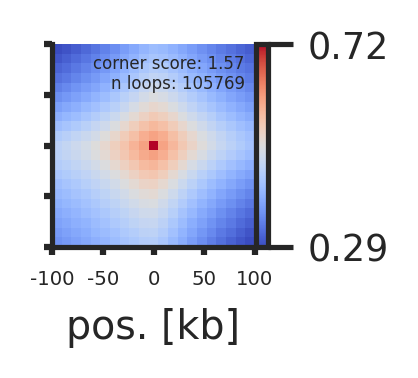

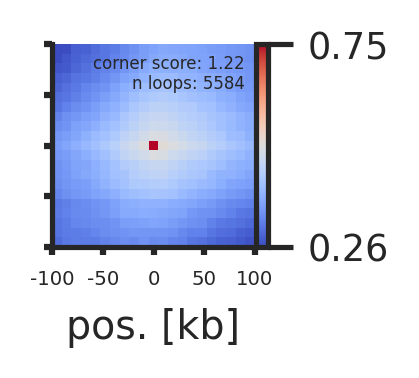

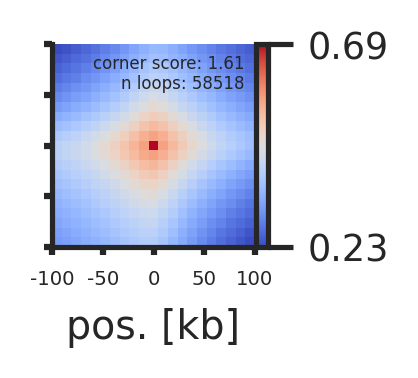

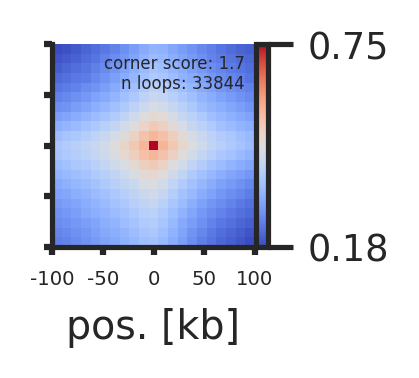

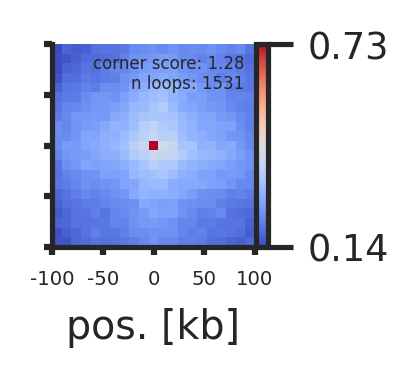

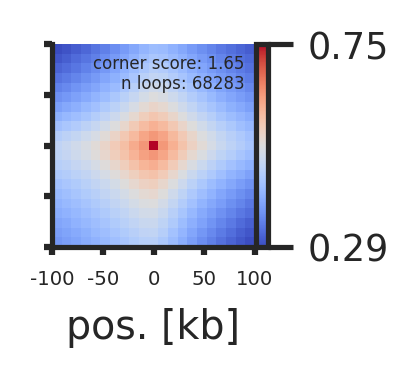

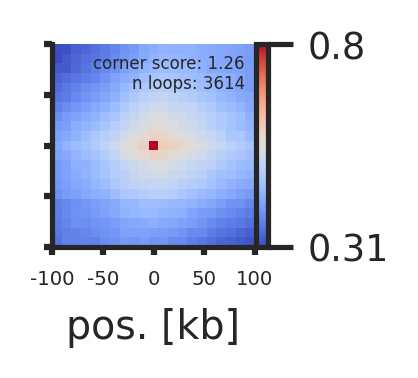

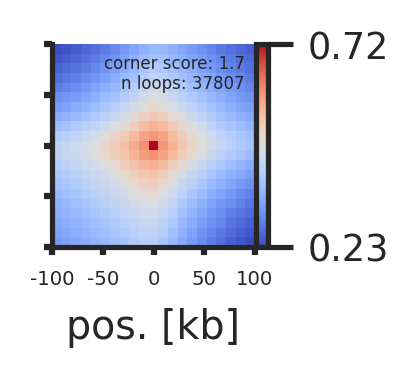

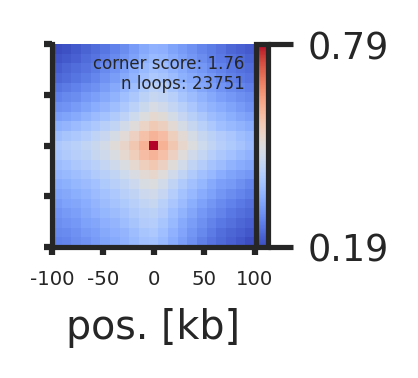

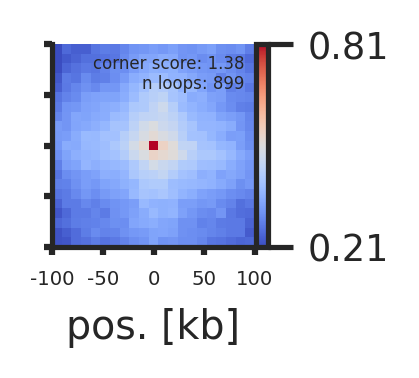

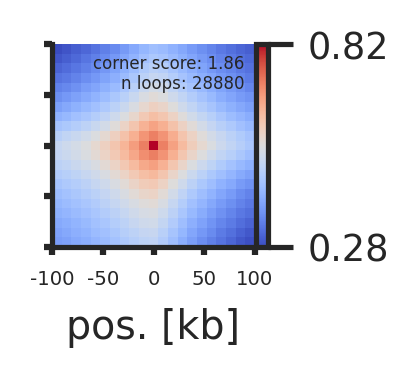

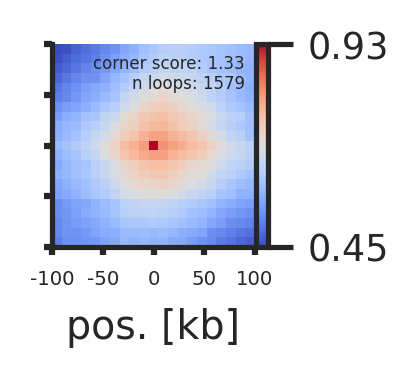

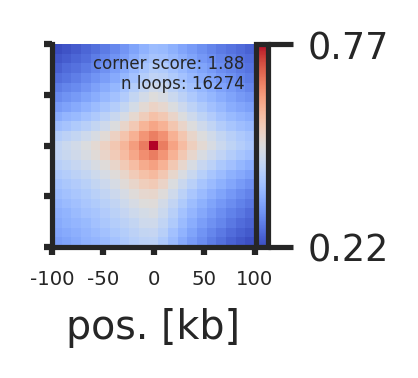

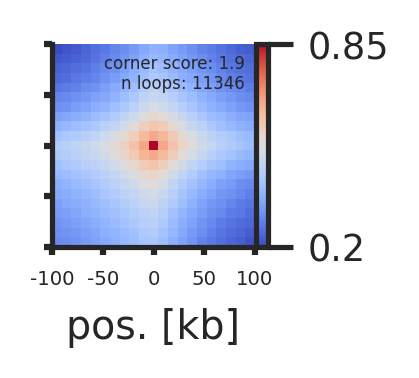

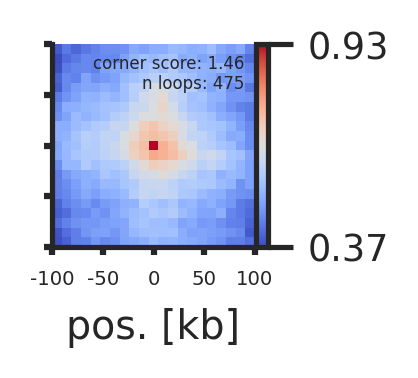

In [11]:
# APA plot of filtered hicdcp loops from each condition

res = 10

for cutoffs in [0.1, 0.05, 0.01]:
	for sample in ['G1DMSO_pooled', 'G1dTAG_pooled', 'G1A485_pooled', 'EpiG1DMSO_pooled', 'EpiG1dTAG_pooled']:
		bedpe = f"strict_q{cutoffs}_{sample}_{res}kb"
		print("flag1")
		pup, nloops = callAPAoverLoop(coolDir, sample + '_' + str(res*1000) + 'bp',
				loopDir, bedpe,
				minDiag = 2, byDistance = False,
				balance = 'weight', ooe = True)
		print("flag2")
		fileName = 'strict_APA_' + sample + '_hicdcp_10kb_qval' + str(cutoffs)
		drawAPA(pup, nloops, scale = 'log10', colormap = 'coolwarm', vmax = False, vmin = False,
				fileDir = figDir, fileName = fileName)
		print("flag3")
		# drawAPA(pup, nloops, scale = 'log10', colormap = 'coolwarm', vmax = 1, vmin = 0,
		#           fileDir = figDir, fileName = fileName + '_minmax')



In [ ]:
res = '5'
maxV = 0.6
for sample in ['D3-DMSO_pooled', 'D3-dTAG_pooled']:
    pup, nloops = callAPAoverLoop(coolDir, sample + '_' + str(res) + 'kb',
              loopDir, 'chromo_cons_allRes_postprocessed_DMSO_specific',
              minDiag = 2, byDistance = False,
              balance = 'weight', ooe = True)
    fileName = 'APA_DMSOspecific_' + sample
    drawAPA(pup, nloops, scale = 'log10', colormap = 'coolwarm', vmax = False, vmin = False,
            fileDir = figDir, fileName = fileName)
    drawAPA(pup, nloops, scale = 'log10', colormap = 'coolwarm', vmax = maxV, vmin = 0,
            fileDir = figDir, fileName = fileName + '_minmax')

for sample in ['D3-DMSO_pooled', 'D3-dTAG_pooled']:
    pup, nloops = callAPAoverLoop(coolDir, sample + '_' + str(res) + 'kb',
              loopDir, 'chromo_cons_allRes_postprocessed_dTAG_specific',
              minDiag = 2, byDistance = False,
              balance = 'weight', ooe = True)
    fileName = 'APA_dTAGspecific_' + sample
    drawAPA(pup, nloops, scale = 'log10', colormap = 'coolwarm', vmax = False, vmin = False,
            fileDir = figDir, fileName = fileName)
    drawAPA(pup, nloops, scale = 'log10', colormap = 'coolwarm', vmax = maxV, vmin = 0,
            fileDir = figDir, fileName = fileName + '_minmax')

for sample in ['D3-DMSO_pooled', 'D3-dTAG_pooled']:
    pup, nloops = callAPAoverLoop(coolDir, sample + '_' + str(res) + 'kb',
              loopDir, 'chromo_cons_allRes_postprocessed_common',
              minDiag = 2, byDistance = False,
              balance = 'weight', ooe = True)
    fileName = 'APA_common_' + sample
    drawAPA(pup, nloops, scale = 'log10', colormap = 'coolwarm', vmax = False, vmin = False,
            fileDir = figDir, fileName = fileName)
    drawAPA(pup, nloops, scale = 'log10', colormap = 'coolwarm', vmax = maxV, vmin = 0,
            fileDir = figDir, fileName = fileName + '_minmax')

In [ ]:
res = '5'
maxV = 0.6
for sample in ['D3-DMSO_pooled', 'D3-dTAG_pooled']:
    pup, nloops = callAPAoverLoop(coolDir, sample + '_' + str(res) + 'kb',
              loopDir, 'chromo_cons_allRes_postprocessed_NCAPH2_TT',
              minDiag = 2, byDistance = False,
              balance = 'weight', ooe = True)
    fileName = 'APA_NCAPH2_TT_' + sample
    drawAPA(pup, nloops, scale = 'log10', colormap = 'coolwarm', vmax = False, vmin = False,
            fileDir = figDir, fileName = fileName)
    drawAPA(pup, nloops, scale = 'log10', colormap = 'coolwarm', vmax = 0.35, vmin = 0,
            fileDir = figDir, fileName = fileName + '_minmax')

for sample in ['D3-DMSO_pooled', 'D3-dTAG_pooled']:
    pup, nloops = callAPAoverLoop(coolDir, sample + '_' + str(res) + 'kb',
              loopDir, 'chromo_cons_allRes_postprocessed_NCAPH2_TFFT_TForder',
              minDiag = 2, byDistance = False,
              balance = 'weight', ooe = True)
    fileName = 'APA_NCAPH2_TF_' + sample
    drawAPA(pup, nloops, scale = 'log10', colormap = 'coolwarm', vmax = False, vmin = False,
            fileDir = figDir, fileName = fileName)
    drawAPA(pup, nloops, scale = 'log10', colormap = 'coolwarm', vmax = 0.4, vmin = 0,
            fileDir = figDir, fileName = fileName + '_minmax')

for sample in ['D3-DMSO_pooled', 'D3-dTAG_pooled']:
    pup, nloops = callAPAoverLoop(coolDir, sample + '_' + str(res) + 'kb',
              loopDir, 'chromo_cons_allRes_postprocessed_NCAPH2_FF',
              minDiag = 2, byDistance = False,
              balance = 'weight', ooe = True)
    fileName = 'APA_NCAPH2_FF_' + sample
    drawAPA(pup, nloops, scale = 'log10', colormap = 'coolwarm', vmax = False, vmin = False,
            fileDir = figDir, fileName = fileName)
    drawAPA(pup, nloops, scale = 'log10', colormap = 'coolwarm', vmax = 0.5, vmin = 0,
            fileDir = figDir, fileName = fileName + '_minmax')

In [ ]:
## ARCHIES BELOW THIS

In [ ]:
for name in ['no', 'within', 'outside']:
    for sample in ['G1.DMSO.Merged', 'G1.dTAG.Merged']:
        pup = callAPAoverLoop(coolDir, sample + '_' + str(res) + 'kb',
                              loopDir, 'insulated_domain_ps_' + name,
                              minDist = 50, minDiag = 21, byDistance = False,
                              balance = 'weight', ooe = True)
        fileName = 'APA_' + name + '_ps_' + sample 
        drawAPA(pup, scale = 'log10', colormap = 'coolwarm', vmax = False, vmin = False,
                fileDir = figDir, fileName = fileName)
        drawAPA(pup, scale = 'log10', colormap = 'coolwarm', vmax = 0.3, vmin = 0,
                fileDir = figDir, fileName = fileName + 'vminmax')
# DONE

In [ ]:
for name in ['pe-pe_reg', 'pe-pe_str']:
    for sample in ['G1.DMSO.Merged', 'G1.dTAG.Merged']:
        pup = callAPAoverLoop(coolDir, sample + '_' + str(res) + 'kb',
                              loopDir, 'chromo_cons_annoHierarchy_' + name,
                              minDist = 50, minDiag = 21, byDistance = False,
                              balance = 'weight', ooe = True)
        fileName = 'APA_' + name + '_' + sample 
        drawAPA(pup, scale = 'log10', colormap = 'coolwarm', vmax = False, vmin = False,
                fileDir = figDir, fileName = fileName)
        drawAPA(pup, scale = 'log10', colormap = 'coolwarm', vmax = 0.4, vmin = -0.1,
                fileDir = figDir, fileName = fileName + 'vminmax')
# DONE

In [ ]:
for name in ['regulatory', 'structure', 'p-n', 'pe-pe', 'p-p', 'p-s', 'p-x', 'p-e',  'p-pe', 'x-x']:
    for sample in ['G1.DMSO.Merged', 'G1.dTAG.Merged', 'G1.A485.Merged']:
        pup = callAPAoverLoop(coolDir, sample + '_' + str(res) + 'kb',
                              loopDir, 'chromo_cons_annoHierarchy_' + name,
                              minDist = 50, minDiag = 21, byDistance = False,
                              balance = 'weight', ooe = True)
        fileName = 'APA_' + name + '_' + sample 
        drawAPA(pup, scale = 'log10', colormap = 'coolwarm', vmax = False, vmin = False,
                fileDir = figDir, fileName = fileName)
        drawAPA(pup, scale = 'log10', colormap = 'coolwarm', vmax = 0.4, vmin = -0.1,
                fileDir = figDir, fileName = fileName + 'vminmax')
# DONE

In [ ]:

for sample in ['G1.DMSO.Merged', 'G1.dTAG.Merged']:
    for name in ['structure', 'pe-pe']:
        for deg in ['UP', 'NO', 'DOWN']:
            pup = callAPAoverLoop(coolDir, sample + '_' + str(res) + 'kb',
                                  loopDir, 'chromo_cons_annoHierarchy_' + name + '_dTAGvsDMSO_' + deg + '_diff0.2',
                                  minDist = 50, minDiag = 21, byDistance = False,
                                  balance = 'weight', ooe = True)
            fileName = 'APA_dTAG_vs_DMSO_'+ deg + '_' + name + '_' + sample 
            drawAPA(pup, scale = 'log10', colormap = 'coolwarm', vmax = False, vmin = False,
                    fileDir = figDir, fileName = fileName)
            drawAPA(pup, scale = 'log10', colormap = 'coolwarm', vmax = 0.4, vmin = -0.1,
                    fileDir = figDir, fileName = fileName + 'vminmax')
# DONE

In [ ]:
for sample in ['G1.DMSO.Merged', 'G1.A485.Merged']:
    for name in ['structure', 'pe-pe']:
        for deg in ['UP', 'NO', 'DOWN']:
            pup = callAPAoverLoop(coolDir, sample + '_' + str(res) + 'kb',
                                  loopDir, 'chromo_cons_annoHierarchy_' + name + '_A485vsDMSO_' + deg + '_diff0.2',
                                  minDist = 50, minDiag = 21, byDistance = False,
                                  balance = 'weight', ooe = True)
            fileName = 'APA_A485_vs_DMSO_'+ deg + '_' + name + '_' + sample 
            drawAPA(pup, scale = 'log10', colormap = 'coolwarm', vmax = False, vmin = False,
                    fileDir = figDir, fileName = fileName)
            drawAPA(pup, scale = 'log10', colormap = 'coolwarm', vmax = 0.4, vmin = -0.1,
                    fileDir = figDir, fileName = fileName + 'vminmax')
# DONE

In [ ]:


for sample in ['G1.DMSO.Merged', 'G1.dTAG.Merged', 'G1.A485.Merged']:
    for name in ['all', 'regulatory', 'structure', 'pe-pe', 'p-p', 'p-e', 'e-e', 'x-x']:
        pup = callAPAoverLoop(coolDir, sample + '_' + str(res) + 'kb',
                              loopDir, 'chromo_cons_' + name,
                              minDist = 50, minDiag = 21, byDistance = False,
                              balance = 'weight', ooe = True)
        fileName = 'APA_' + name + '_' + sample 
        drawAPA(pup, scale = 'log10', colormap = 'coolwarm', vmax = False, vmin = False,
                fileDir = figDir, fileName = fileName)
        drawAPA(pup, scale = 'log10', colormap = 'coolwarm', vmax = 0.4, vmin = -0.1,
                fileDir = figDir, fileName = fileName + 'vminmax')


In [ ]:

for sample in ['G1.DMSO.Merged', 'G1.dTAG.Merged']:
    for name in ['all', 'regulatory', 'structure', 'pe-pe', 'p-p', 'p-e', 'e-e', 'x-x']:
        for deg in ['UP', 'NO', 'DOWN']:
            pup = callAPAoverLoop(coolDir, sample + '_' + str(res) + 'kb',
                                  loopDir, 'chromo_cons_dTAG_vs_DMSO_' + deg + '_' + name,
                                  minDist = 50, minDiag = 21, byDistance = False,
                                  balance = 'weight', ooe = True)
            fileName = 'APA_dTAG_vs_DMSO_'+ deg + '_' + name + '_' + sample 
            drawAPA(pup, scale = 'log10', colormap = 'coolwarm', vmax = False, vmin = False,
                    fileDir = figDir, fileName = fileName)
            drawAPA(pup, scale = 'log10', colormap = 'coolwarm', vmax = 0.4, vmin = -0.1,
                    fileDir = figDir, fileName = fileName + 'vminmax')

In [ ]:


for sample in ['G1.DMSO.Merged', 'G1.A485.Merged']:
    for name in ['all', 'regulatory', 'structure', 'pe-pe', 'p-p', 'p-e', 'e-e', 'x-x']:
        for deg in ['UP', 'NO', 'DOWN']:
            pup = callAPAoverLoop(coolDir, sample + '_' + str(res) + 'kb',
                                  loopDir, 'chromo_cons_A485_vs_DMSO_' + deg + '_' + name,
                                  minDist = 50, minDiag = 21, byDistance = False,
                                  balance = 'weight', ooe = True)
            fileName = 'APA_A485_vs_DMSO_'+ deg + '_' + name + '_' + sample 
            drawAPA(pup, scale = 'log10', colormap = 'coolwarm', vmax = False, vmin = False,
                    fileDir = figDir, fileName = fileName)
            drawAPA(pup, scale = 'log10', colormap = 'coolwarm', vmax = 0.4, vmin = -0.1,
                    fileDir = figDir, fileName = fileName + 'vminmax')


In [ ]:
for sample in ['HiChIP-H3K4me3_G1-RAD21-DMSO_rep1_5kb', 'HiChIP-H3K4me3_G1-RAD21-dTAG_rep1_5kb', 
               'HiChIP-H3K4me3_G1-RAD21-DMSO_rep2_5kb', 'HiChIP-H3K4me3_G1-RAD21-dTAG_rep2_5kb']:
    for loop in ['Tjian_chromosight_loops_regulatory', 'Tjian_chromosight_loops_structure',
                 'MicroC_G1-RAD21-DMSO_pool_chromosight_allRes_regulatory', 'MicroC_G1-RAD21-DMSO_pool_chromosight_allRes_structure',
                 'MicroC_G1-RAD21-DMSO_pool_chromosight_allRes_dTAGcom_regulatory', 'MicroC_G1-RAD21-DMSO_pool_chromosight_allRes_dTAGcom_structure',
                 'MicroC_G1-RAD21-dTAG_pool_chromosight_allRes_regulatory', 'MicroC_G1-RAD21-dTAG_pool_chromosight_allRes_structure',
                 'MicroC_G1DMSO_Merged_nb_vardisp_spline_5kb_0_2000000_count-based_qval0.05_regulatory', 'MicroC_G1DMSO_Merged_nb_vardisp_spline_5kb_0_2000000_count-based_qval0.05_structure',
                 'MicroC_G1dTAG_Merged_nb_vardisp_spline_5kb_0_2000000_count-based_qval0.05_regulatory', 'MicroC_G1dTAG_Merged_nb_vardisp_spline_5kb_0_2000000_count-based_qval0.05_structure',
                 'HiChIP_HiCDCP_10kb.resCom.G1.DMSO_regulatory', 'HiChIP_HiCDCP_10kb.resCom.G1.DMSO_structure',
                 'HiChIP_HiCDCP_10kb.resCom.G1.common_regulatory', 'HiChIP_HiCDCP_10kb.resCom.G1.common_structure',
                 'HiChIP_HiCDCP_10kb.resCom.G1.dTAG_regulatory', 'HiChIP_HiCDCP_10kb.resCom.G1.dTAG_structure']:
        pup = callAPAoverLoop('../data/cool', sample, 
                         '../data/loop', loop,
                         minDist = 50, minDiag = 21, byDistance = False,
                         balance = 'weight', ooe = True)
        fileName = 'APA_' + sample + '_' + loop 
        drawAPA(pup, scale = 'log10', colormap = 'coolwarm', vmax = 0.4, vmin = -0.1,
                fileDir = 'pileup_trial2', fileName = fileName)
        

In [ ]:
min = 50
# Pileup all loops longer than cutoff
pup_DMSO = coolpup.pileup(clr_G1DMSO, loop_all, features_format='bedpe',
                     local=False, min_diag=21, by_distance=False, mindist=min*1000,
                     nproc=8)

vmax = 25/6
vmin = 0
fg1 = plotpup.plot(pup_DMSO,
             cmap='coolwarm',
             score = False, vmax = vmax, vmin = vmin,
             scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
file1 = figDir + '/chromo_cons.svg'
fg1.savefig(file1, format = 'svg')


In [ ]:
sample = "MicroC"
treatment = "G1dTAG"

# Loading cool files
cool_file_DMSO = "data/mcool/" + sample + "_G1DMSO_Merged_5kbcorr.cool"
cool_file_dTAG = "data/mcool/" + sample + "_G1dTAG_Merged_5kbcorr.cool"
clr_DMSO = cooler.Cooler(f'{cool_file_DMSO}')
clr_dTAG = cooler.Cooler(f'{cool_file_dTAG}')

# Loading loops
loop_file = "loop_calling_chromosight/" + sample + "_" + treatment + "_Merged_chromosight_25.10.5kb_specific.bedpe"
loop = pd.read_csv(loop_file, sep = '\t', header = None).iloc[:, :6]
loop.columns = ['chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2']

min = 50
# Pileup all loops longer than cutoff
pup_DMSO = coolpup.pileup(clr_DMSO, loop, features_format='bedpe',
                     local=False, min_diag=21, by_distance=False, mindist=min*1000,
                     nproc=8)
pup_dTAG = coolpup.pileup(clr_dTAG, loop, features_format='bedpe',
                     local=False, min_diag=21, by_distance=False, mindist=min*1000,
                     nproc=8)

# Make figure

vmax = 25/6
vmin = 0
fg1 = plotpup.plot(pup_DMSO,
             cmap='coolwarm',
             score = False, vmax = vmax, vmin = vmin,
             scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
fg2 = plotpup.plot(pup_dTAG,
             cmap='coolwarm',
             score = False, vmax = vmax, vmin = vmin,
             scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
file1 = "pileup/APA_loop-Chromosight-" + sample + "-" + treatment + "-" + "25.10.5" + "kb_on_MicroC.G1.DMSO_" + str(min) + "kb_specific.svg"
file2 = "pileup/APA_loop-Chromosight-" + sample + "-" + treatment + "-" + "25.10.5" + "kb_on_MicroC.G1.dTAG_" + str(min) + "kb_specific.svg"
fg1.savefig(file1, format = 'svg')
fg2.savefig(file2, format = 'svg')


# Pileup loop subset by distance
mindist = 0
pup_DMSO = coolpup.pileup(clr_DMSO, loop, features_format='bedpe',
                      local=False, mindist=mindist , by_distance=True, min_diag=21,
                      nproc=8)
pup_dTAG = coolpup.pileup(clr_dTAG, loop, features_format='bedpe',
                      local=False, mindist=mindist , by_distance=True, min_diag=21,
                      nproc=8)

# Make figure
for i in [3, 5, 10, 20, 40]:
    vmax = 25/i
    vmin = 0
    fg3 = plotpup.plot(pup_DMSO,
                 cmap='coolwarm',
                 score = False, vmax = vmax, vmin = vmin,
                 scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
    fg4 = plotpup.plot(pup_dTAG,
                 cmap='coolwarm',
                 score = False, vmax = vmax, vmin = vmin,
                 scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
    file3 = "pileup/APA_loop-Chromosight-" + sample + "-" + treatment + "-" + "25.10.5" + "kb_on_MicroC.G1.DMSO_split_" + str(i) + "kb_specific.svg"
    file4 = "pileup/APA_loop-Chromosight-" + sample + "-" + treatment + "-" + "25.10.5" + "kb_on_MicroC.G1.dTAG_split_" + str(i) + "kb_specific.svg"
    fg3.savefig(file3, format = 'svg')
    fg4.savefig(file4, format = 'svg')

In [ ]:
ctcf['quartile_FC_score'] = pd.qcut(ctcf['FC_score'], 4, labels=False) + 1
ctcf['peaks_importance'] = ctcf.apply(
    lambda x: 'Top by FC score' if x.quartile_FC_score==4 else 'Ordinary peaks', axis=1
)


In [ ]:
# Select the CTCF sites that are in top quartile by both the ChIP-Seq data and motif score

sites = ctcf[ctcf['peaks_importance']=='Top by FC score']\
    .sort_values('FC_score', ascending=False)\
    .reset_index(drop=True)
sites.tail()

In [ ]:
sites.to_csv('annotated_ctcf_sites.tsv', sep='\t', index=False, header=False) # Let's save to use in CLI


## Loop pile up

### Understanding how APA plot works

#### Comparing APA plotted in different resolution

In [ ]:
# Merged loops
loop_file = "loop_calling_chromosight/MicroC_G1DMSO_Merged_chromosight_25.10.5kb.bedpe"
loop = pd.read_csv(loop_file, sep = '\t', header = None).iloc[:, :6]
loop.columns = ['chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2']

# Loading cool files
sample = "MicroC"
treatment = "G1DMSO"
resolution = 5
cool_file_DMSO = "data/mcool/" + sample + "_G1DMSO_Merged_" + str(resolution) + "kbcorr.cool"
cool_file_dTAG = "data/mcool/" + sample + "_G1dTAG_Merged_" + str(resolution) + "kbcorr.cool"
clr_DMSO = cooler.Cooler(f'{cool_file_DMSO}')
clr_dTAG = cooler.Cooler(f'{cool_file_dTAG}')

pup_DMSO_5kb = coolpup.pileup(clr_DMSO, loop, features_format='bedpe',
                     local=False, rescale=False, mindist=0 , by_distance=True, min_diag=21,
                     nproc=8)

resolution = 10
cool_file_DMSO = "data/mcool/" + sample + "_G1DMSO_Merged_" + str(resolution) + "kbcorr.cool"
cool_file_dTAG = "data/mcool/" + sample + "_G1dTAG_Merged_" + str(resolution) + "kbcorr.cool"
clr_DMSO = cooler.Cooler(f'{cool_file_DMSO}')
clr_dTAG = cooler.Cooler(f'{cool_file_dTAG}')

pup_DMSO_10kb = coolpup.pileup(clr_DMSO, loop, features_format='bedpe',
                     local=False, rescale=False, mindist=0 , by_distance=True, min_diag=11,
                     nproc=8)

resolution = 25
cool_file_DMSO = "data/mcool/" + sample + "_G1DMSO_Merged_" + str(resolution) + "kbcorr.cool"
cool_file_dTAG = "data/mcool/" + sample + "_G1dTAG_Merged_" + str(resolution) + "kbcorr.cool"
clr_DMSO = cooler.Cooler(f'{cool_file_DMSO}')
clr_dTAG = cooler.Cooler(f'{cool_file_dTAG}')

pup_DMSO_25kb = coolpup.pileup(clr_DMSO, loop, features_format='bedpe',
                     local=False, rescale=False, mindist=0 , by_distance=True, min_diag=5,
                     nproc=8)


In [ ]:
#flank = resolution*1000*10
i = 8
fg1 = plotpup.plot(pup_DMSO_25kb,
             cmap='coolwarm',
             score = False, vmin = 0, vmax = 625/i,
             scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
fg1 = plotpup.plot(pup_DMSO_10kb,
             cmap='coolwarm',
             score = False, vmin = 0, vmax = 100/i,
             scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
fg1 = plotpup.plot(pup_DMSO_5kb,
             cmap='coolwarm',
             score = False, vmin = 0, vmax = 25/i,
             scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)

#### Comparing APA plots with different color scales

In [ ]:
#flank = resolution*1000*10
i = 2
fg1 = plotpup.plot(pup_DMSO_5kb,
             cmap='coolwarm',
             score = False, vmin = 0, vmax = 25/i,
             scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
#flank = resolution*1000*10
i = 3
fg1 = plotpup.plot(pup_DMSO_5kb,
             cmap='coolwarm',
             score = False, vmin = 0, vmax = 25/i,
             scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
#flank = resolution*1000*10
i = 4
fg1 = plotpup.plot(pup_DMSO_5kb,
             cmap='coolwarm',
             score = False, vmin = 0, vmax = 25/i,
             scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
#flank = resolution*1000*10
i = 5
fg1 = plotpup.plot(pup_DMSO_5kb,
             cmap='coolwarm',
             score = False, vmin = 0, vmax = 25/i,
             scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
#flank = resolution*1000*10
i = 6
fg1 = plotpup.plot(pup_DMSO_5kb,
             cmap='coolwarm',
             score = False, vmin = 0, vmax = 25/i,
             scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
#flank = resolution*1000*10
i = 7
fg1 = plotpup.plot(pup_DMSO_5kb,
             cmap='coolwarm',
             score = False, vmin = 0, vmax = 25/i,
             scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
#flank = resolution*1000*10
i = 8
fg1 = plotpup.plot(pup_DMSO_5kb,
             cmap='coolwarm',
             score = False, vmin = 0, vmax = 25/i,
             scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
#flank = resolution*1000*10
i = 9
fg1 = plotpup.plot(pup_DMSO_5kb,
             cmap='coolwarm',
             score = False, vmin = 0, vmax = 25/i,
             scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
#flank = resolution*1000*10
i = 10
fg1 = plotpup.plot(pup_DMSO_5kb,
             cmap='coolwarm',
             score = False, vmin = 0, vmax = 25/i,
             scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
#flank = resolution*1000*10
i = 15
fg1 = plotpup.plot(pup_DMSO_5kb,
             cmap='coolwarm',
             score = False, vmin = 0, vmax = 25/i,
             scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
#flank = resolution*1000*10
i = 20
fg1 = plotpup.plot(pup_DMSO_5kb,
             cmap='coolwarm',
             score = False, vmin = 0, vmax = 25/i,
             scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
#flank = resolution*1000*10
i = 40
fg1 = plotpup.plot(pup_DMSO_5kb,
             cmap='coolwarm',
             score = False, vmin = 0, vmax = 25/i,
             scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
#flank = resolution*1000*10
i = 80
fg1 = plotpup.plot(pup_DMSO_5kb,
             cmap='coolwarm',
             score = False, vmin = 0, vmax = 25/i,
             scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)

In [ ]:
sample = "MicroC"
treatment = "G1DMSO"
resolution = 5
cool_file_DMSO = "data/mcool/" + sample + "_G1DMSO_Merged_" + str(resolution) + "kbcorr.cool"
cool_file_dTAG = "data/mcool/" + sample + "_G1dTAG_Merged_" + str(resolution) + "kbcorr.cool"
clr_DMSO = cooler.Cooler(f'{cool_file_DMSO}')
clr_dTAG = cooler.Cooler(f'{cool_file_dTAG}')

pup_DMSO_5kb = coolpup.pileup(clr_DMSO, loop, features_format='bedpe',
                     local=False, rescale=False, mindist=50000 , by_distance=False, min_diag=21,
                     nproc=8)

In [ ]:
i = 6
fg1 = plotpup.plot(pup_DMSO_5kb,
                     cmap='coolwarm',
                     score = False, vmin = 0, vmax = 25/i,
                     scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)

### [Chromosight loops]

### Comparing loops called in different resolution

#### DMSO

In [ ]:
sample = "MicroC"
treatment = "G1DMSO"

# Loading cool files
cool_file_DMSO = "data/mcool/" + sample + "_G1DMSO_Merged_5kbcorr.cool"
cool_file_dTAG = "data/mcool/" + sample + "_G1dTAG_Merged_5kbcorr.cool"
clr_DMSO = cooler.Cooler(f'{cool_file_DMSO}')
clr_dTAG = cooler.Cooler(f'{cool_file_dTAG}')

for resolution in [25, 10, 5]:
    # Loading loops
    loop_file = "loop_calling_chromosight/" + sample + "_" + treatment + "_Merged_chromosight_" + str(resolution) + "kb.bedpe"
    loop = pd.read_csv(loop_file, sep = '\t', header = None).iloc[:, :6]
    loop.columns = ['chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2']
        
    # Pileup all loops longer than cutoff
    pup_DMSO = coolpup.pileup(clr_DMSO, loop, features_format='bedpe',
                         local=False, min_diag=21, by_distance=False,
                         nproc=8)
    pup_dTAG = coolpup.pileup(clr_dTAG, loop, features_format='bedpe',
                         local=False, min_diag=21, by_distance=False,
                         nproc=8)
    
    # Make figure
    
    vmax = 25/6
    vmin = 0
    fg1 = plotpup.plot(pup_DMSO,
                 cmap='coolwarm',
                 score = False,  vmax = vmax, vmin = vmin,
                 scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
    fg2 = plotpup.plot(pup_dTAG,
                 cmap='coolwarm',
                 score = False, vmax = vmax, vmin = vmin,
                 scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
    file1 = "pileup/APA_loop-Chromosight-" + sample + "-" + treatment + "-" + str(resolution) + "kb_on_MicroC.G1.DMSO.svg"
    file2 = "pileup/APA_loop-Chromosight-" + sample + "-" + treatment + "-" + str(resolution) + "kb_on_MicroC.G1.dTAG.svg"
    
    fg1.savefig(file1, format = 'svg')
    fg2.savefig(file2, format = 'svg')
    
    # Pileup loop subset by distance
    mindist = 0
    pup_DMSO = coolpup.pileup(clr_DMSO, loop, features_format='bedpe',
                              local=False, mindist=mindist , by_distance=True, min_diag=21,
                              nproc=8)
    pup_dTAG = coolpup.pileup(clr_dTAG, loop, features_format='bedpe',
                              local=False, mindist=mindist , by_distance=True, min_diag=21,
                              nproc=8)
    
    # Make figure
    for i in [3, 5, 10, 20, 40]:
        vmax = 25/i
        vmin = 0
        fg3 = plotpup.plot(pup_DMSO,
                     cmap='coolwarm',
                     score = False, vmax = vmax, vmin = vmin,
                     scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
        fg4 = plotpup.plot(pup_dTAG,
                     cmap='coolwarm',
                     score = False, vmax = vmax, vmin = vmin,
                     scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
        file3 = "pileup/APA_loop-Chromosight-" + sample + "-" + treatment + "-" + str(resolution) + "kb_on_MicroC.G1.DMSO_split_" + str(i) + ".svg"
        file4 = "pileup/APA_loop-Chromosight-" + sample + "-" + treatment + "-" + str(resolution) + "kb_on_MicroC.G1.dTAG_split_" + str(i) + ".svg"
        fg3.savefig(file3, format = 'svg')
        fg4.savefig(file4, format = 'svg')

#### dTAG

In [ ]:
sample = "MicroC"
treatment = "G1dTAG"

# Loading cool files
cool_file_dTAG = "data/mcool/" + sample + "_G1dTAG_Merged_5kbcorr.cool"
clr_dTAG = cooler.Cooler(f'{cool_file_dTAG}')

for resolution in [25, 10, 5]:
    # Loading loops
    loop_file = "loop_calling_chromosight/" + sample + "_" + treatment + "_Merged_chromosight_" + str(resolution) + "kb.bedpe"
    loop = pd.read_csv(loop_file, sep = '\t', header = None).iloc[:, :6]
    loop.columns = ['chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2']
        
    # Pileup all loops longer than cutoff
    pup_dTAG = coolpup.pileup(clr_dTAG, loop, features_format='bedpe',
                         local=False, min_diag=21, by_distance=False,
                         nproc=8)
    
    # Make figure
    
    vmax = 25/6
    vmin = 0
    fg2 = plotpup.plot(pup_dTAG,
                 cmap='coolwarm',
                 score = False, vmax = vmax, vmin = vmin,
                 scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
    file2 = "pileup/APA_loop-Chromosight-" + sample + "-" + treatment + "-" + str(resolution) + "kb_on_MicroC.G1.dTAG.svg"
    
    fg2.savefig(file2, format = 'svg')
    
    # Pileup loop subset by distance
    mindist = 0
     pup_dTAG = coolpup.pileup(clr_dTAG, loop, features_format='bedpe',
                              local=False, mindist=mindist , by_distance=True, min_diag=21,
                              nproc=8)
    
    # Make figure
    for i in [3, 5, 10, 20, 40]:
        vmax = 25/i
        vmin = 0
        fg4 = plotpup.plot(pup_dTAG,
                     cmap='coolwarm',
                     score = False, vmax = vmax, vmin = vmin,
                     scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
        file4 = "pileup/APA_loop-Chromosight-" + sample + "-" + treatment + "-" + str(resolution) + "kb_on_MicroC.G1.dTAG_split_" + str(i) + ".svg"
        fg4.savefig(file4, format = 'svg')

#### Merged loops - DMSO


In [ ]:
sample = "MicroC"
treatment = "G1DMSO"

# Loading cool files
cool_file_DMSO = "data/mcool/" + sample + "_G1DMSO_Merged_5kbcorr.cool"
cool_file_dTAG = "data/mcool/" + sample + "_G1dTAG_Merged_5kbcorr.cool"
clr_DMSO = cooler.Cooler(f'{cool_file_DMSO}')
clr_dTAG = cooler.Cooler(f'{cool_file_dTAG}')

# Loading loops
loop_file = "loop_calling_chromosight/" + sample + "_" + treatment + "_Merged_chromosight_25.10.5kb.bedpe"
loop = pd.read_csv(loop_file, sep = '\t', header = None).iloc[:, :6]
loop.columns = ['chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2']

min = 50
# Pileup all loops longer than cutoff
pup_DMSO = coolpup.pileup(clr_DMSO, loop, features_format='bedpe',
                     local=False, min_diag=21, by_distance=False, mindist=min*1000,
                     nproc=8)
pup_dTAG = coolpup.pileup(clr_dTAG, loop, features_format='bedpe',
                     local=False, min_diag=21, by_distance=False, mindist=min*1000,
                     nproc=8)

# Make figure

vmax = 25/6
vmin = 0
fg1 = plotpup.plot(pup_DMSO,
             cmap='coolwarm',
             score = False, vmax = vmax, vmin = vmin,
             scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
fg2 = plotpup.plot(pup_dTAG,
             cmap='coolwarm',
             score = False, vmax = vmax, vmin = vmin,
             scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
file1 = "pileup/APA_loop-Chromosight-" + sample + "-" + treatment + "-" + "25.10.5" + "kb_on_MicroC.G1.DMSO_" + str(min) + "kb.svg"
file2 = "pileup/APA_loop-Chromosight-" + sample + "-" + treatment + "-" + "25.10.5" + "kb_on_MicroC.G1.dTAG_" + str(min) + "kb.svg"
fg1.savefig(file1, format = 'svg')
fg2.savefig(file2, format = 'svg')

In [ ]:
# Pileup loop subset by distance
mindist = 0
pup_DMSO = coolpup.pileup(clr_DMSO, loop, features_format='bedpe',
                      local=False, mindist=mindist , by_distance=True, min_diag=21,
                      nproc=8)
pup_dTAG = coolpup.pileup(clr_dTAG, loop, features_format='bedpe',
                      local=False, mindist=mindist , by_distance=True, min_diag=21,
                      nproc=8)

# Make figure
for i in [3, 5, 10, 20, 40]:
    vmax = 25/i
    vmin = 0
    fg3 = plotpup.plot(pup_DMSO,
                 cmap='coolwarm',
                 score = False, vmax = vmax, vmin = vmin,
                 scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
    fg4 = plotpup.plot(pup_dTAG,
                 cmap='coolwarm',
                 score = False, vmax = vmax, vmin = vmin,
                 scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
    file3 = "pileup/APA_loop-Chromosight-" + sample + "-" + treatment + "-" + "25.10.5" + "kb_on_MicroC.G1.DMSO_split_" + str(i) + ".svg"
    file4 = "pileup/APA_loop-Chromosight-" + sample + "-" + treatment + "-" + "25.10.5" + "kb_on_MicroC.G1.dTAG_split_" + str(i) + ".svg"
    fg3.savefig(file3, format = 'svg')
    fg4.savefig(file4, format = 'svg')

#### Merged loops - dTAG


In [ ]:
sample = "MicroC"
treatment = "G1dTAG"

# Loading cool files
cool_file_DMSO = "data/mcool/" + sample + "_G1DMSO_Merged_5kbcorr.cool"
cool_file_dTAG = "data/mcool/" + sample + "_G1dTAG_Merged_5kbcorr.cool"
clr_DMSO = cooler.Cooler(f'{cool_file_DMSO}')
clr_dTAG = cooler.Cooler(f'{cool_file_dTAG}')

# Loading loops
loop_file = "loop_calling_chromosight/" + sample + "_" + treatment + "_Merged_chromosight_25.10.5kb.bedpe"
loop = pd.read_csv(loop_file, sep = '\t', header = None).iloc[:, :6]
loop.columns = ['chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2']

min = 50
# Pileup all loops longer than cutoff
pup_DMSO = coolpup.pileup(clr_DMSO, loop, features_format='bedpe',
                     local=False, min_diag=21, by_distance=False, mindist=min*1000,
                     nproc=8)
pup_dTAG = coolpup.pileup(clr_dTAG, loop, features_format='bedpe',
                     local=False, min_diag=21, by_distance=False, mindist=min*1000,
                     nproc=8)

# Make figure

vmax = 25/6
vmin = 0
fg1 = plotpup.plot(pup_DMSO,
             cmap='coolwarm',
             score = False, vmax = vmax, vmin = vmin,
             scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
fg2 = plotpup.plot(pup_dTAG,
             cmap='coolwarm',
             score = False, vmax = vmax, vmin = vmin,
             scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
file1 = "pileup/APA_loop-Chromosight-" + sample + "-" + treatment + "-" + "25.10.5" + "kb_on_MicroC.G1.DMSO_" + str(min) + "kb.svg"
file2 = "pileup/APA_loop-Chromosight-" + sample + "-" + treatment + "-" + "25.10.5" + "kb_on_MicroC.G1.dTAG_" + str(min) + "kb.svg"
fg1.savefig(file1, format = 'svg')
fg2.savefig(file2, format = 'svg')


# Pileup loop subset by distance
mindist = 0
pup_DMSO = coolpup.pileup(clr_DMSO, loop, features_format='bedpe',
                      local=False, mindist=mindist , by_distance=True, min_diag=21,
                      nproc=8)
pup_dTAG = coolpup.pileup(clr_dTAG, loop, features_format='bedpe',
                      local=False, mindist=mindist , by_distance=True, min_diag=21,
                      nproc=8)

# Make figure
for i in [3, 5, 10, 20, 40]:
    vmax = 25/i
    vmin = 0
    fg3 = plotpup.plot(pup_DMSO,
                 cmap='coolwarm',
                 score = False, vmax = vmax, vmin = vmin,
                 scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
    fg4 = plotpup.plot(pup_dTAG,
                 cmap='coolwarm',
                 score = False, vmax = vmax, vmin = vmin,
                 scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
    file3 = "pileup/APA_loop-Chromosight-" + sample + "-" + treatment + "-" + "25.10.5" + "kb_on_MicroC.G1.DMSO_split_" + str(i) + ".svg"
    file4 = "pileup/APA_loop-Chromosight-" + sample + "-" + treatment + "-" + "25.10.5" + "kb_on_MicroC.G1.dTAG_split_" + str(i) + ".svg"
    fg3.savefig(file3, format = 'svg')
    fg4.savefig(file4, format = 'svg')

#### DMSO/dTAG common loops

In [ ]:
sample = "MicroC"
treatment = "G1DMSO"

# Loading cool files
cool_file_DMSO = "data/mcool/" + sample + "_G1DMSO_Merged_5kbcorr.cool"
cool_file_dTAG = "data/mcool/" + sample + "_G1dTAG_Merged_5kbcorr.cool"
clr_DMSO = cooler.Cooler(f'{cool_file_DMSO}')
clr_dTAG = cooler.Cooler(f'{cool_file_dTAG}')

# Loading loops
loop_file = "loop_calling_chromosight/" + sample + "_" + treatment + "_Merged_chromosight_25.10.5kb_common.bedpe"
loop = pd.read_csv(loop_file, sep = '\t', header = None).iloc[:, :6]
loop.columns = ['chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2']

min = 50
# Pileup all loops longer than cutoff
pup_DMSO = coolpup.pileup(clr_DMSO, loop, features_format='bedpe',
                     local=False, min_diag=21, by_distance=False, mindist=min*1000,
                     nproc=8)
pup_dTAG = coolpup.pileup(clr_dTAG, loop, features_format='bedpe',
                     local=False, min_diag=21, by_distance=False, mindist=min*1000,
                     nproc=8)

# Make figure

vmax = 25/6
vmin = 0
fg1 = plotpup.plot(pup_DMSO,
             cmap='coolwarm',
             score = False, vmax = vmax, vmin = vmin,
             scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
fg2 = plotpup.plot(pup_dTAG,
             cmap='coolwarm',
             score = False, vmax = vmax, vmin = vmin,
             scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
file1 = "pileup/APA_loop-Chromosight-" + sample + "-" + treatment + "-" + "25.10.5" + "kb_on_MicroC.G1.DMSO_" + str(min) + "kb_common.svg"
file2 = "pileup/APA_loop-Chromosight-" + sample + "-" + treatment + "-" + "25.10.5" + "kb_on_MicroC.G1.dTAG_" + str(min) + "kb_common.svg"
fg1.savefig(file1, format = 'svg')
fg2.savefig(file2, format = 'svg')


# Pileup loop subset by distance
mindist = 0
pup_DMSO = coolpup.pileup(clr_DMSO, loop, features_format='bedpe',
                      local=False, mindist=mindist , by_distance=True, min_diag=21,
                      nproc=8)
pup_dTAG = coolpup.pileup(clr_dTAG, loop, features_format='bedpe',
                      local=False, mindist=mindist , by_distance=True, min_diag=21,
                      nproc=8)

# Make figure
for i in [3, 5, 10, 20, 40]:
    vmax = 25/i
    vmin = 0
    fg3 = plotpup.plot(pup_DMSO,
                 cmap='coolwarm',
                 score = False, vmax = vmax, vmin = vmin,
                 scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
    fg4 = plotpup.plot(pup_dTAG,
                 cmap='coolwarm',
                 score = False, vmax = vmax, vmin = vmin,
                 scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
    file3 = "pileup/APA_loop-Chromosight-" + sample + "-" + treatment + "-" + "25.10.5" + "kb_on_MicroC.G1.DMSO_split_" + str(i) + "_common.svg"
    file4 = "pileup/APA_loop-Chromosight-" + sample + "-" + treatment + "-" + "25.10.5" + "kb_on_MicroC.G1.dTAG_split_" + str(i) + "_common.svg"
    fg3.savefig(file3, format = 'svg')
    fg4.savefig(file4, format = 'svg')

#### Merged loops - DMSO specific loops

In [ ]:
sample = "MicroC"
treatment = "G1DMSO"

# Loading cool files
cool_file_DMSO = "data/mcool/" + sample + "_G1DMSO_Merged_5kbcorr.cool"
cool_file_dTAG = "data/mcool/" + sample + "_G1dTAG_Merged_5kbcorr.cool"
clr_DMSO = cooler.Cooler(f'{cool_file_DMSO}')
clr_dTAG = cooler.Cooler(f'{cool_file_dTAG}')

# Loading loops
loop_file = "loop_calling_chromosight/" + sample + "_" + treatment + "_Merged_chromosight_25.10.5kb_specific.bedpe"
loop = pd.read_csv(loop_file, sep = '\t', header = None).iloc[:, :6]
loop.columns = ['chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2']

min = 50
# Pileup all loops longer than cutoff
pup_DMSO = coolpup.pileup(clr_DMSO, loop, features_format='bedpe',
                     local=False, min_diag=21, by_distance=False, mindist=min*1000,
                     nproc=8)
pup_dTAG = coolpup.pileup(clr_dTAG, loop, features_format='bedpe',
                     local=False, min_diag=21, by_distance=False, mindist=min*1000,
                     nproc=8)

# Make figure

vmax = 25/6
vmin = 0
fg1 = plotpup.plot(pup_DMSO,
             cmap='coolwarm',
             score = False, vmax = vmax, vmin = vmin,
             scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
fg2 = plotpup.plot(pup_dTAG,
             cmap='coolwarm',
             score = False, vmax = vmax, vmin = vmin,
             scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
file1 = "pileup/APA_loop-Chromosight-" + sample + "-" + treatment + "-" + "25.10.5" + "kb_on_MicroC.G1.DMSO_" + str(min) + "kb_specific.svg"
file2 = "pileup/APA_loop-Chromosight-" + sample + "-" + treatment + "-" + "25.10.5" + "kb_on_MicroC.G1.dTAG_" + str(min) + "kb_specific.svg"
fg1.savefig(file1, format = 'svg')
fg2.savefig(file2, format = 'svg')


# Pileup loop subset by distance
mindist = 0
pup_DMSO = coolpup.pileup(clr_DMSO, loop, features_format='bedpe',
                      local=False, mindist=mindist , by_distance=True, min_diag=21,
                      nproc=8)
pup_dTAG = coolpup.pileup(clr_dTAG, loop, features_format='bedpe',
                      local=False, mindist=mindist , by_distance=True, min_diag=21,
                      nproc=8)

# Make figure
for i in [3, 5, 10, 20, 40]:
    vmax = 25/i
    vmin = 0
    fg3 = plotpup.plot(pup_DMSO,
                 cmap='coolwarm',
                 score = False, vmax = vmax, vmin = vmin,
                 scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
    fg4 = plotpup.plot(pup_dTAG,
                 cmap='coolwarm',
                 score = False, vmax = vmax, vmin = vmin,
                 scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
    file3 = "pileup/APA_loop-Chromosight-" + sample + "-" + treatment + "-" + "25.10.5" + "kb_on_MicroC.G1.DMSO_split_" + str(i) + "kb_specific.svg"
    file4 = "pileup/APA_loop-Chromosight-" + sample + "-" + treatment + "-" + "25.10.5" + "kb_on_MicroC.G1.dTAG_split_" + str(i) + "kb_specific.svg"
    fg3.savefig(file3, format = 'svg')
    fg4.savefig(file4, format = 'svg')

#### Merged loops - dTAG specific loops

In [ ]:
sample = "MicroC"
treatment = "G1dTAG"

# Loading cool files
cool_file_DMSO = "data/mcool/" + sample + "_G1DMSO_Merged_5kbcorr.cool"
cool_file_dTAG = "data/mcool/" + sample + "_G1dTAG_Merged_5kbcorr.cool"
clr_DMSO = cooler.Cooler(f'{cool_file_DMSO}')
clr_dTAG = cooler.Cooler(f'{cool_file_dTAG}')

# Loading loops
loop_file = "loop_calling_chromosight/" + sample + "_" + treatment + "_Merged_chromosight_25.10.5kb_specific.bedpe"
loop = pd.read_csv(loop_file, sep = '\t', header = None).iloc[:, :6]
loop.columns = ['chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2']

min = 50
# Pileup all loops longer than cutoff
pup_DMSO = coolpup.pileup(clr_DMSO, loop, features_format='bedpe',
                     local=False, min_diag=21, by_distance=False, mindist=min*1000,
                     nproc=8)
pup_dTAG = coolpup.pileup(clr_dTAG, loop, features_format='bedpe',
                     local=False, min_diag=21, by_distance=False, mindist=min*1000,
                     nproc=8)

# Make figure

vmax = 25/6
vmin = 0
fg1 = plotpup.plot(pup_DMSO,
             cmap='coolwarm',
             score = False, vmax = vmax, vmin = vmin,
             scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
fg2 = plotpup.plot(pup_dTAG,
             cmap='coolwarm',
             score = False, vmax = vmax, vmin = vmin,
             scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
file1 = "pileup/APA_loop-Chromosight-" + sample + "-" + treatment + "-" + "25.10.5" + "kb_on_MicroC.G1.DMSO_" + str(min) + "kb_specific.svg"
file2 = "pileup/APA_loop-Chromosight-" + sample + "-" + treatment + "-" + "25.10.5" + "kb_on_MicroC.G1.dTAG_" + str(min) + "kb_specific.svg"
fg1.savefig(file1, format = 'svg')
fg2.savefig(file2, format = 'svg')


# Pileup loop subset by distance
mindist = 0
pup_DMSO = coolpup.pileup(clr_DMSO, loop, features_format='bedpe',
                      local=False, mindist=mindist , by_distance=True, min_diag=21,
                      nproc=8)
pup_dTAG = coolpup.pileup(clr_dTAG, loop, features_format='bedpe',
                      local=False, mindist=mindist , by_distance=True, min_diag=21,
                      nproc=8)

# Make figure
for i in [3, 5, 10, 20, 40]:
    vmax = 25/i
    vmin = 0
    fg3 = plotpup.plot(pup_DMSO,
                 cmap='coolwarm',
                 score = False, vmax = vmax, vmin = vmin,
                 scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
    fg4 = plotpup.plot(pup_dTAG,
                 cmap='coolwarm',
                 score = False, vmax = vmax, vmin = vmin,
                 scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
    file3 = "pileup/APA_loop-Chromosight-" + sample + "-" + treatment + "-" + "25.10.5" + "kb_on_MicroC.G1.DMSO_split_" + str(i) + "kb_specific.svg"
    file4 = "pileup/APA_loop-Chromosight-" + sample + "-" + treatment + "-" + "25.10.5" + "kb_on_MicroC.G1.dTAG_split_" + str(i) + "kb_specific.svg"
    fg3.savefig(file3, format = 'svg')
    fg4.savefig(file4, format = 'svg')

### [Mustache loops]

### Comparing loops called in different resolution

#### DMSO


In [ ]:
sample = "MicroC"
treatment = "G1DMSO"

# Loading cool files
cool_file_DMSO = "data/mcool/" + sample + "_G1DMSO_Merged_5kbcorr.cool"
cool_file_dTAG = "data/mcool/" + sample + "_G1dTAG_Merged_5kbcorr.cool"
clr_DMSO = cooler.Cooler(f'{cool_file_DMSO}')
clr_dTAG = cooler.Cooler(f'{cool_file_dTAG}')

for resolution in [25, 10, 5]:
    # Loading loops
    loop_file = "loop_calling_mustache/" + sample + "_" + treatment + "_Merged_mustache_" + str(resolution) + "kb.bedpe"
    loop = pd.read_csv(loop_file, sep = '\t', header = None).iloc[:, :6]
    loop.columns = ['chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2']
        
    # Pileup all loops longer than cutoff
    pup_DMSO = coolpup.pileup(clr_DMSO, loop, features_format='bedpe',
                         local=False, min_diag=21, by_distance=False,
                         nproc=8)
    pup_dTAG = coolpup.pileup(clr_dTAG, loop, features_format='bedpe',
                         local=False, min_diag=21, by_distance=False,
                         nproc=8)
    
    # Make figure
    
    vmax = 25/6
    vmin = 0
    fg1 = plotpup.plot(pup_DMSO,
                 cmap='coolwarm',
                 score = False,  vmax = vmax, vmin = vmin,
                 scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
    fg2 = plotpup.plot(pup_dTAG,
                 cmap='coolwarm',
                 score = False, vmax = vmax, vmin = vmin,
                 scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
    file1 = "pileup/APA_loop-mustache-" + sample + "-" + treatment + "-" + str(resolution) + "kb_on_MicroC.G1.DMSO.svg"
    file2 = "pileup/APA_loop-mustache-" + sample + "-" + treatment + "-" + str(resolution) + "kb_on_MicroC.G1.dTAG.svg"
    
    fg1.savefig(file1, format = 'svg')
    fg2.savefig(file2, format = 'svg')
    
    # Pileup loop subset by distance
    mindist = 0
    pup_DMSO = coolpup.pileup(clr_DMSO, loop, features_format='bedpe',
                              local=False, mindist=mindist , by_distance=True, min_diag=21,
                              nproc=8)
    pup_dTAG = coolpup.pileup(clr_dTAG, loop, features_format='bedpe',
                              local=False, mindist=mindist , by_distance=True, min_diag=21,
                              nproc=8)
    
    # Make figure
    for i in [3, 5, 10, 20, 40]:
        vmax = 25/i
        vmin = 0
        fg3 = plotpup.plot(pup_DMSO,
                     cmap='coolwarm',
                     score = False, vmax = vmax, vmin = vmin,
                     scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
        fg4 = plotpup.plot(pup_dTAG,
                     cmap='coolwarm',
                     score = False, vmax = vmax, vmin = vmin,
                     scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
        file3 = "pileup/APA_loop-mustache-" + sample + "-" + treatment + "-" + str(resolution) + "kb_on_MicroC.G1.DMSO_split_" + str(i) + ".svg"
        file4 = "pileup/APA_loop-mustache-" + sample + "-" + treatment + "-" + str(resolution) + "kb_on_MicroC.G1.dTAG_split_" + str(i) + ".svg"
        fg3.savefig(file3, format = 'svg')
        fg4.savefig(file4, format = 'svg')

#### dTAG

In [ ]:
sample = "MicroC"
treatment = "G1dTAG"

# Loading cool files
cool_file_dTAG = "data/mcool/" + sample + "_G1dTAG_Merged_5kbcorr.cool"
clr_dTAG = cooler.Cooler(f'{cool_file_dTAG}')

for resolution in [25, 10, 5]:
    # Loading loops
    loop_file = "loop_calling_mustache/" + sample + "_" + treatment + "_Merged_mustache_" + str(resolution) + "kb.bedpe"
    loop = pd.read_csv(loop_file, sep = '\t', header = None).iloc[:, :6]
    loop.columns = ['chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2']
        
    # Pileup all loops longer than cutoff
    pup_dTAG = coolpup.pileup(clr_dTAG, loop, features_format='bedpe',
                         local=False, min_diag=21, by_distance=False,
                         nproc=8)
    
    # Make figure
    
    vmax = 25/6
    vmin = 0
    fg2 = plotpup.plot(pup_dTAG,
                 cmap='coolwarm',
                 score = False, vmax = vmax, vmin = vmin,
                 scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
    file2 = "pileup/APA_loop-mustache-" + sample + "-" + treatment + "-" + str(resolution) + "kb_on_MicroC.G1.dTAG.svg"
    
    fg2.savefig(file2, format = 'svg')
    
    # Pileup loop subset by distance
    mindist = 0
    pup_dTAG = coolpup.pileup(clr_dTAG, loop, features_format='bedpe',
                              local=False, mindist=mindist , by_distance=True, min_diag=21,
                              nproc=8)
    
    # Make figure
    for i in [3, 5, 10, 20, 40]:
        vmax = 25/i
        vmin = 0
        fg4 = plotpup.plot(pup_dTAG,
                     cmap='coolwarm',
                     score = False, vmax = vmax, vmin = vmin,
                     scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
        file4 = "pileup/APA_loop-mustache-" + sample + "-" + treatment + "-" + str(resolution) + "kb_on_MicroC.G1.dTAG_split_" + str(i) + ".svg"
        fg4.savefig(file4, format = 'svg')

#### Merged loops - DMSO

In [ ]:
sample = "MicroC"
treatment = "G1DMSO"

# Loading cool files
cool_file_DMSO = "data/mcool/" + sample + "_G1DMSO_Merged_5kbcorr.cool"
cool_file_dTAG = "data/mcool/" + sample + "_G1dTAG_Merged_5kbcorr.cool"
clr_DMSO = cooler.Cooler(f'{cool_file_DMSO}')
clr_dTAG = cooler.Cooler(f'{cool_file_dTAG}')

# Loading loops
loop_file = "loop_calling_mustache/" + sample + "_" + treatment + "_Merged_mustache_25.10.5kb.bedpe"
loop = pd.read_csv(loop_file, sep = '\t', header = None).iloc[:, :6]
loop.columns = ['chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2']

min = 50
# Pileup all loops longer than cutoff
pup_DMSO = coolpup.pileup(clr_DMSO, loop, features_format='bedpe',
                     local=False, min_diag=21, by_distance=False, mindist=min*1000,
                     nproc=8)
pup_dTAG = coolpup.pileup(clr_dTAG, loop, features_format='bedpe',
                     local=False, min_diag=21, by_distance=False, mindist=min*1000,
                     nproc=8)

# Make figure

vmax = 25/6
vmin = 0
fg1 = plotpup.plot(pup_DMSO,
             cmap='coolwarm',
             score = False, vmax = vmax, vmin = vmin,
             scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
fg2 = plotpup.plot(pup_dTAG,
             cmap='coolwarm',
             score = False, vmax = vmax, vmin = vmin,
             scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
file1 = "pileup/APA_loop-mustache-" + sample + "-" + treatment + "-" + "25.10.5" + "kb_on_MicroC.G1.DMSO_" + str(min) + "kb.svg"
file2 = "pileup/APA_loop-mustache-" + sample + "-" + treatment + "-" + "25.10.5" + "kb_on_MicroC.G1.dTAG_" + str(min) + "kb.svg"
fg1.savefig(file1, format = 'svg')
fg2.savefig(file2, format = 'svg')



# Pileup loop subset by distance
mindist = 0
pup_DMSO = coolpup.pileup(clr_DMSO, loop, features_format='bedpe',
                      local=False, mindist=mindist , by_distance=True, min_diag=21,
                      nproc=8)
pup_dTAG = coolpup.pileup(clr_dTAG, loop, features_format='bedpe',
                      local=False, mindist=mindist , by_distance=True, min_diag=21,
                      nproc=8)

# Make figure
for i in [3, 5, 10, 20, 40]:
    vmax = 25/i
    vmin = 0
    fg3 = plotpup.plot(pup_DMSO,
                 cmap='coolwarm',
                 score = False, vmax = vmax, vmin = vmin,
                 scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
    fg4 = plotpup.plot(pup_dTAG,
                 cmap='coolwarm',
                 score = False, vmax = vmax, vmin = vmin,
                 scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
    file3 = "pileup/APA_loop-mustache-" + sample + "-" + treatment + "-" + "25.10.5" + "kb_on_MicroC.G1.DMSO_split_" + str(i) + ".svg"
    file4 = "pileup/APA_loop-mustache-" + sample + "-" + treatment + "-" + "25.10.5" + "kb_on_MicroC.G1.dTAG_split_" + str(i) + ".svg"
    fg3.savefig(file3, format = 'svg')
    fg4.savefig(file4, format = 'svg')

#### Merged loops - dTAG

In [ ]:
sample = "MicroC"
treatment = "G1dTAG"

# Loading cool files
cool_file_DMSO = "data/mcool/" + sample + "_G1DMSO_Merged_5kbcorr.cool"
cool_file_dTAG = "data/mcool/" + sample + "_G1dTAG_Merged_5kbcorr.cool"
clr_DMSO = cooler.Cooler(f'{cool_file_DMSO}')
clr_dTAG = cooler.Cooler(f'{cool_file_dTAG}')

# Loading loops
loop_file = "loop_calling_mustache/" + sample + "_" + treatment + "_Merged_mustache_25.10.5kb.bedpe"
loop = pd.read_csv(loop_file, sep = '\t', header = None).iloc[:, :6]
loop.columns = ['chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2']

min = 50
# Pileup all loops longer than cutoff
pup_DMSO = coolpup.pileup(clr_DMSO, loop, features_format='bedpe',
                     local=False, min_diag=21, by_distance=False, mindist=min*1000,
                     nproc=8)
pup_dTAG = coolpup.pileup(clr_dTAG, loop, features_format='bedpe',
                     local=False, min_diag=21, by_distance=False, mindist=min*1000,
                     nproc=8)

# Make figure

vmax = 25/6
vmin = 0
fg1 = plotpup.plot(pup_DMSO,
             cmap='coolwarm',
             score = False, vmax = vmax, vmin = vmin,
             scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
fg2 = plotpup.plot(pup_dTAG,
             cmap='coolwarm',
             score = False, vmax = vmax, vmin = vmin,
             scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
file1 = "pileup/APA_loop-mustache-" + sample + "-" + treatment + "-" + "25.10.5" + "kb_on_MicroC.G1.DMSO_" + str(min) + "kb.svg"
file2 = "pileup/APA_loop-mustache-" + sample + "-" + treatment + "-" + "25.10.5" + "kb_on_MicroC.G1.dTAG_" + str(min) + "kb.svg"
fg1.savefig(file1, format = 'svg')
fg2.savefig(file2, format = 'svg')


# Pileup loop subset by distance
mindist = 0
pup_DMSO = coolpup.pileup(clr_DMSO, loop, features_format='bedpe',
                      local=False, mindist=mindist , by_distance=True, min_diag=21,
                      nproc=8)
pup_dTAG = coolpup.pileup(clr_dTAG, loop, features_format='bedpe',
                      local=False, mindist=mindist , by_distance=True, min_diag=21,
                      nproc=8)

# Make figure
for i in [3, 5, 10, 20, 40]:
    vmax = 25/i
    vmin = 0
    fg3 = plotpup.plot(pup_DMSO,
                 cmap='coolwarm',
                 score = False, vmax = vmax, vmin = vmin,
                 scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
    fg4 = plotpup.plot(pup_dTAG,
                 cmap='coolwarm',
                 score = False, vmax = vmax, vmin = vmin,
                 scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
    file3 = "pileup/APA_loop-mustache-" + sample + "-" + treatment + "-" + "25.10.5" + "kb_on_MicroC.G1.DMSO_split_" + str(i) + ".svg"
    file4 = "pileup/APA_loop-mustache-" + sample + "-" + treatment + "-" + "25.10.5" + "kb_on_MicroC.G1.dTAG_split_" + str(i) + ".svg"
    fg3.savefig(file3, format = 'svg')
    fg4.savefig(file4, format = 'svg')

#### common loops

In [ ]:
sample = "MicroC"
treatment = "G1DMSO"

# Loading cool files
cool_file_DMSO = "data/mcool/" + sample + "_G1DMSO_Merged_5kbcorr.cool"
cool_file_dTAG = "data/mcool/" + sample + "_G1dTAG_Merged_5kbcorr.cool"
clr_DMSO = cooler.Cooler(f'{cool_file_DMSO}')
clr_dTAG = cooler.Cooler(f'{cool_file_dTAG}')

# Loading loops
loop_file = "loop_calling_mustache/" + sample + "_" + treatment + "_Merged_mustache_25.10.5kb_common.bedpe"
loop = pd.read_csv(loop_file, sep = '\t', header = None).iloc[:, :6]
loop.columns = ['chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2']

min = 50
# Pileup all loops longer than cutoff
pup_DMSO = coolpup.pileup(clr_DMSO, loop, features_format='bedpe',
                     local=False, min_diag=21, by_distance=False, mindist=min*1000,
                     nproc=8)
pup_dTAG = coolpup.pileup(clr_dTAG, loop, features_format='bedpe',
                     local=False, min_diag=21, by_distance=False, mindist=min*1000,
                     nproc=8)

# Make figure

vmax = 25/6
vmin = 0
fg1 = plotpup.plot(pup_DMSO,
             cmap='coolwarm',
             score = False, vmax = vmax, vmin = vmin,
             scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
fg2 = plotpup.plot(pup_dTAG,
             cmap='coolwarm',
             score = False, vmax = vmax, vmin = vmin,
             scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
file1 = "pileup/APA_loop-mustache-" + sample + "-" + treatment + "-" + "25.10.5" + "kb_on_MicroC.G1.DMSO_" + str(min) + "kb_common.svg"
file2 = "pileup/APA_loop-mustache-" + sample + "-" + treatment + "-" + "25.10.5" + "kb_on_MicroC.G1.dTAG_" + str(min) + "kb_common.svg"
fg1.savefig(file1, format = 'svg')
fg2.savefig(file2, format = 'svg')


# Pileup loop subset by distance
mindist = 0
pup_DMSO = coolpup.pileup(clr_DMSO, loop, features_format='bedpe',
                      local=False, mindist=mindist , by_distance=True, min_diag=21,
                      nproc=8)
pup_dTAG = coolpup.pileup(clr_dTAG, loop, features_format='bedpe',
                      local=False, mindist=mindist , by_distance=True, min_diag=21,
                      nproc=8)

# Make figure
for i in [3, 5, 10, 20, 40]:
    vmax = 25/i
    vmin = 0
    fg3 = plotpup.plot(pup_DMSO,
                 cmap='coolwarm',
                 score = False, vmax = vmax, vmin = vmin,
                 scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
    fg4 = plotpup.plot(pup_dTAG,
                 cmap='coolwarm',
                 score = False, vmax = vmax, vmin = vmin,
                 scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
    file3 = "pileup/APA_loop-mustache-" + sample + "-" + treatment + "-" + "25.10.5" + "kb_on_MicroC.G1.DMSO_split_" + str(i) + "_common.svg"
    file4 = "pileup/APA_loop-mustache-" + sample + "-" + treatment + "-" + "25.10.5" + "kb_on_MicroC.G1.dTAG_split_" + str(i) + "_common.svg"
    fg3.savefig(file3, format = 'svg')
    fg4.savefig(file4, format = 'svg')

#### DMSO specific loops

In [ ]:
sample = "MicroC"
treatment = "G1DMSO"

# Loading cool files
cool_file_DMSO = "data/mcool/" + sample + "_G1DMSO_Merged_5kbcorr.cool"
cool_file_dTAG = "data/mcool/" + sample + "_G1dTAG_Merged_5kbcorr.cool"
clr_DMSO = cooler.Cooler(f'{cool_file_DMSO}')
clr_dTAG = cooler.Cooler(f'{cool_file_dTAG}')

# Loading loops
loop_file = "loop_calling_mustache/" + sample + "_" + treatment + "_Merged_mustache_25.10.5kb_specific.bedpe"
loop = pd.read_csv(loop_file, sep = '\t', header = None).iloc[:, :6]
loop.columns = ['chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2']

min = 50
# Pileup all loops longer than cutoff
pup_DMSO = coolpup.pileup(clr_DMSO, loop, features_format='bedpe',
                     local=False, min_diag=21, by_distance=False, mindist=min*1000,
                     nproc=8)
pup_dTAG = coolpup.pileup(clr_dTAG, loop, features_format='bedpe',
                     local=False, min_diag=21, by_distance=False, mindist=min*1000,
                     nproc=8)

# Make figure

vmax = 25/6
vmin = 0
fg1 = plotpup.plot(pup_DMSO,
             cmap='coolwarm',
             score = False, vmax = vmax, vmin = vmin,
             scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
fg2 = plotpup.plot(pup_dTAG,
             cmap='coolwarm',
             score = False, vmax = vmax, vmin = vmin,
             scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
file1 = "pileup/APA_loop-mustache-" + sample + "-" + treatment + "-" + "25.10.5" + "kb_on_MicroC.G1.DMSO_" + str(min) + "kb_specific.svg"
file2 = "pileup/APA_loop-mustache-" + sample + "-" + treatment + "-" + "25.10.5" + "kb_on_MicroC.G1.dTAG_" + str(min) + "kb_specific.svg"
fg1.savefig(file1, format = 'svg')
fg2.savefig(file2, format = 'svg')


# Pileup loop subset by distance
mindist = 0
pup_DMSO = coolpup.pileup(clr_DMSO, loop, features_format='bedpe',
                      local=False, mindist=mindist , by_distance=True, min_diag=21,
                      nproc=8)
pup_dTAG = coolpup.pileup(clr_dTAG, loop, features_format='bedpe',
                      local=False, mindist=mindist , by_distance=True, min_diag=21,
                      nproc=8)

# Make figure
for i in [3, 5, 10, 20, 40]:
    vmax = 25/i
    vmin = 0
    fg3 = plotpup.plot(pup_DMSO,
                 cmap='coolwarm',
                 score = False, vmax = vmax, vmin = vmin,
                 scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
    fg4 = plotpup.plot(pup_dTAG,
                 cmap='coolwarm',
                 score = False, vmax = vmax, vmin = vmin,
                 scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
    file3 = "pileup/APA_loop-mustache-" + sample + "-" + treatment + "-" + "25.10.5" + "kb_on_MicroC.G1.DMSO_split_" + str(i) + "kb_specific.svg"
    file4 = "pileup/APA_loop-mustache-" + sample + "-" + treatment + "-" + "25.10.5" + "kb_on_MicroC.G1.dTAG_split_" + str(i) + "kb_specific.svg"
    fg3.savefig(file3, format = 'svg')
    fg4.savefig(file4, format = 'svg')

#### dTAG specific loops

In [ ]:
sample = "MicroC"
treatment = "G1dTAG"

# Loading cool files
cool_file_DMSO = "data/mcool/" + sample + "_G1DMSO_Merged_5kbcorr.cool"
cool_file_dTAG = "data/mcool/" + sample + "_G1dTAG_Merged_5kbcorr.cool"
clr_DMSO = cooler.Cooler(f'{cool_file_DMSO}')
clr_dTAG = cooler.Cooler(f'{cool_file_dTAG}')

# Loading loops
loop_file = "loop_calling_mustache/" + sample + "_" + treatment + "_Merged_mustache_25.10.5kb_specific.bedpe"
loop = pd.read_csv(loop_file, sep = '\t', header = None).iloc[:, :6]
loop.columns = ['chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2']

min = 50
# Pileup all loops longer than cutoff
pup_DMSO = coolpup.pileup(clr_DMSO, loop, features_format='bedpe',
                     local=False, min_diag=21, by_distance=False, mindist=min*1000,
                     nproc=8)
pup_dTAG = coolpup.pileup(clr_dTAG, loop, features_format='bedpe',
                     local=False, min_diag=21, by_distance=False, mindist=min*1000,
                     nproc=8)

# Make figure

vmax = 25/6
vmin = 0
fg1 = plotpup.plot(pup_DMSO,
             cmap='coolwarm',
             score = False, vmax = vmax, vmin = vmin,
             scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
fg2 = plotpup.plot(pup_dTAG,
             cmap='coolwarm',
             score = False, vmax = vmax, vmin = vmin,
             scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
file1 = "pileup/APA_loop-mustache-" + sample + "-" + treatment + "-" + "25.10.5" + "kb_on_MicroC.G1.DMSO_" + str(min) + "kb_specific.svg"
file2 = "pileup/APA_loop-mustache-" + sample + "-" + treatment + "-" + "25.10.5" + "kb_on_MicroC.G1.dTAG_" + str(min) + "kb_specific.svg"
fg1.savefig(file1, format = 'svg')
fg2.savefig(file2, format = 'svg')


# Pileup loop subset by distance
mindist = 0
pup_DMSO = coolpup.pileup(clr_DMSO, loop, features_format='bedpe',
                      local=False, mindist=mindist , by_distance=True, min_diag=21,
                      nproc=8)
pup_dTAG = coolpup.pileup(clr_dTAG, loop, features_format='bedpe',
                      local=False, mindist=mindist , by_distance=True, min_diag=21,
                      nproc=8)

# Make figure
for i in [3, 5, 10, 20, 40]:
    vmax = 25/i
    vmin = 0
    fg3 = plotpup.plot(pup_DMSO,
                 cmap='coolwarm',
                 score = False, vmax = vmax, vmin = vmin,
                 scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
    fg4 = plotpup.plot(pup_dTAG,
                 cmap='coolwarm',
                 score = False, vmax = vmax, vmin = vmin,
                 scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
    file3 = "pileup/APA_loop-mustache-" + sample + "-" + treatment + "-" + "25.10.5" + "kb_on_MicroC.G1.DMSO_split_" + str(i) + "kb_specific.svg"
    file4 = "pileup/APA_loop-mustache-" + sample + "-" + treatment + "-" + "25.10.5" + "kb_on_MicroC.G1.dTAG_split_" + str(i) + "kb_specific.svg"
    fg3.savefig(file3, format = 'svg')
    fg4.savefig(file4, format = 'svg')

### Comparing Chromosight vs Mustache


In [ ]:
sample = "MicroC"
treatment = "G1DMSO"
loopCall = "chromosight"
note = "commonWithMustache"

# Loading cool files
cool_file_DMSO = "data/mcool/" + sample + "_G1DMSO_Merged_5kbcorr.cool"
cool_file_dTAG = "data/mcool/" + sample + "_G1dTAG_Merged_5kbcorr.cool"
clr_DMSO = cooler.Cooler(f'{cool_file_DMSO}')
clr_dTAG = cooler.Cooler(f'{cool_file_dTAG}')

# Loading loops
loop_file = "loop_calling_" + loopCall + "/" + sample + "_" + treatment + "_Merged_" + loopCall + "_25.10.5kb_" + note + ".bedpe"
loop = pd.read_csv(loop_file, sep = '\t', header = None).iloc[:, :6]
loop.columns = ['chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2']

min = 50
# Pileup all loops longer than cutoff
pup_DMSO = coolpup.pileup(clr_DMSO, loop, features_format='bedpe',
                     local=False, min_diag=21, by_distance=False, mindist=min*1000,
                     nproc=8)
pup_dTAG = coolpup.pileup(clr_dTAG, loop, features_format='bedpe',
                     local=False, min_diag=21, by_distance=False, mindist=min*1000,
                     nproc=8)

# Make figure

vmax = 25/6
vmin = 0
fg1 = plotpup.plot(pup_DMSO,
             cmap='coolwarm',
             score = False, vmax = vmax, vmin = vmin,
             scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
fg2 = plotpup.plot(pup_dTAG,
             cmap='coolwarm',
             score = False, vmax = vmax, vmin = vmin,
             scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
file1 = "pileup/APA_loop-" + loopCall + "-" + sample + "-" + treatment + "-" + "25.10.5" + "kb_on_MicroC.G1.DMSO_" + str(min) + "kb_" + note + ".svg"
file2 = "pileup/APA_loop-" + loopCall + "-" + sample + "-" + treatment + "-" + "25.10.5" + "kb_on_MicroC.G1.dTAG_" + str(min) + "kb_" + note + ".svg"
fg1.savefig(file1, format = 'svg')
fg2.savefig(file2, format = 'svg')


# Pileup loop subset by distance
mindist = 0
pup_DMSO = coolpup.pileup(clr_DMSO, loop, features_format='bedpe',
                      local=False, mindist=mindist , by_distance=True, min_diag=21,
                      nproc=8)
pup_dTAG = coolpup.pileup(clr_dTAG, loop, features_format='bedpe',
                      local=False, mindist=mindist , by_distance=True, min_diag=21,
                      nproc=8)

# Make figure
for i in [3, 5, 10, 20, 40]:
    vmax = 25/i
    vmin = 0
    fg3 = plotpup.plot(pup_DMSO,
                 cmap='coolwarm',
                 score = False, vmax = vmax, vmin = vmin,
                 scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
    fg4 = plotpup.plot(pup_dTAG,
                 cmap='coolwarm',
                 score = False, vmax = vmax, vmin = vmin,
                 scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
    file3 = "pileup/APA_loop-" + loopCall + "-" + sample + "-" + treatment + "-" + "25.10.5" + "kb_on_MicroC.G1.DMSO_split_" + str(i) + "kb_" + note + ".svg"
    file4 = "pileup/APA_loop-" + loopCall + "-" + sample + "-" + treatment + "-" + "25.10.5" + "kb_on_MicroC.G1.dTAG_split_" + str(i) + "kb_" + note + ".svg"
    fg3.savefig(file3, format = 'svg')
    fg4.savefig(file4, format = 'svg')

In [ ]:
sample = "MicroC"
treatment = "G1DMSO"
loopCall = "chromosight"
note = "notCommonWithMustache"

# Loading cool files
cool_file_DMSO = "data/mcool/" + sample + "_G1DMSO_Merged_5kbcorr.cool"
cool_file_dTAG = "data/mcool/" + sample + "_G1dTAG_Merged_5kbcorr.cool"
clr_DMSO = cooler.Cooler(f'{cool_file_DMSO}')
clr_dTAG = cooler.Cooler(f'{cool_file_dTAG}')

# Loading loops
loop_file = "loop_calling_" + loopCall + "/" + sample + "_" + treatment + "_Merged_" + loopCall + "_25.10.5kb_" + note + ".bedpe"
loop = pd.read_csv(loop_file, sep = '\t', header = None).iloc[:, :6]
loop.columns = ['chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2']

min = 50
# Pileup all loops longer than cutoff
pup_DMSO = coolpup.pileup(clr_DMSO, loop, features_format='bedpe',
                     local=False, min_diag=21, by_distance=False, mindist=min*1000,
                     nproc=8)
pup_dTAG = coolpup.pileup(clr_dTAG, loop, features_format='bedpe',
                     local=False, min_diag=21, by_distance=False, mindist=min*1000,
                     nproc=8)

# Make figure

vmax = 25/6
vmin = 0
fg1 = plotpup.plot(pup_DMSO,
             cmap='coolwarm',
             score = False, vmax = vmax, vmin = vmin,
             scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
fg2 = plotpup.plot(pup_dTAG,
             cmap='coolwarm',
             score = False, vmax = vmax, vmin = vmin,
             scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
file1 = "pileup/APA_loop-" + loopCall + "-" + sample + "-" + treatment + "-" + "25.10.5" + "kb_on_MicroC.G1.DMSO_" + str(min) + "kb_" + note + ".svg"
file2 = "pileup/APA_loop-" + loopCall + "-" + sample + "-" + treatment + "-" + "25.10.5" + "kb_on_MicroC.G1.dTAG_" + str(min) + "kb_" + note + ".svg"
fg1.savefig(file1, format = 'svg')
fg2.savefig(file2, format = 'svg')


# Pileup loop subset by distance
mindist = 0
pup_DMSO = coolpup.pileup(clr_DMSO, loop, features_format='bedpe',
                      local=False, mindist=mindist , by_distance=True, min_diag=21,
                      nproc=8)
pup_dTAG = coolpup.pileup(clr_dTAG, loop, features_format='bedpe',
                      local=False, mindist=mindist , by_distance=True, min_diag=21,
                      nproc=8)

# Make figure
for i in [3, 5, 10, 20, 40]:
    vmax = 25/i
    vmin = 0
    fg3 = plotpup.plot(pup_DMSO,
                 cmap='coolwarm',
                 score = False, vmax = vmax, vmin = vmin,
                 scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
    fg4 = plotpup.plot(pup_dTAG,
                 cmap='coolwarm',
                 score = False, vmax = vmax, vmin = vmin,
                 scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
    file3 = "pileup/APA_loop-" + loopCall + "-" + sample + "-" + treatment + "-" + "25.10.5" + "kb_on_MicroC.G1.DMSO_split_" + str(i) + "kb_" + note + ".svg"
    file4 = "pileup/APA_loop-" + loopCall + "-" + sample + "-" + treatment + "-" + "25.10.5" + "kb_on_MicroC.G1.dTAG_split_" + str(i) + "kb_" + note + ".svg"
    fg3.savefig(file3, format = 'svg')
    fg4.savefig(file4, format = 'svg')

In [ ]:
sample = "MicroC"
treatment = "G1DMSO"
loopCall = "mustache"
note = "notCommonWithChromosight"

# Loading cool files
cool_file_DMSO = "data/mcool/" + sample + "_G1DMSO_Merged_5kbcorr.cool"
cool_file_dTAG = "data/mcool/" + sample + "_G1dTAG_Merged_5kbcorr.cool"
clr_DMSO = cooler.Cooler(f'{cool_file_DMSO}')
clr_dTAG = cooler.Cooler(f'{cool_file_dTAG}')

# Loading loops
loop_file = "loop_calling_" + loopCall + "/" + sample + "_" + treatment + "_Merged_" + loopCall + "_25.10.5kb_" + note + ".bedpe"
loop = pd.read_csv(loop_file, sep = '\t', header = None).iloc[:, :6]
loop.columns = ['chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2']

min = 50
# Pileup all loops longer than cutoff
pup_DMSO = coolpup.pileup(clr_DMSO, loop, features_format='bedpe',
                     local=False, min_diag=21, by_distance=False, mindist=min*1000,
                     nproc=8)
pup_dTAG = coolpup.pileup(clr_dTAG, loop, features_format='bedpe',
                     local=False, min_diag=21, by_distance=False, mindist=min*1000,
                     nproc=8)

# Make figure

vmax = 25/6
vmin = 0
fg1 = plotpup.plot(pup_DMSO,
             cmap='coolwarm',
             score = False, vmax = vmax, vmin = vmin,
             scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
fg2 = plotpup.plot(pup_dTAG,
             cmap='coolwarm',
             score = False, vmax = vmax, vmin = vmin,
             scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
file1 = "pileup/APA_loop-" + loopCall + "-" + sample + "-" + treatment + "-" + "25.10.5" + "kb_on_MicroC.G1.DMSO_" + str(min) + "kb_" + note + ".svg"
file2 = "pileup/APA_loop-" + loopCall + "-" + sample + "-" + treatment + "-" + "25.10.5" + "kb_on_MicroC.G1.dTAG_" + str(min) + "kb_" + note + ".svg"
fg1.savefig(file1, format = 'svg')
fg2.savefig(file2, format = 'svg')


# Pileup loop subset by distance
mindist = 0
pup_DMSO = coolpup.pileup(clr_DMSO, loop, features_format='bedpe',
                      local=False, mindist=mindist , by_distance=True, min_diag=21,
                      nproc=8)
pup_dTAG = coolpup.pileup(clr_dTAG, loop, features_format='bedpe',
                      local=False, mindist=mindist , by_distance=True, min_diag=21,
                      nproc=8)

# Make figure
for i in [3, 5, 10, 20, 40]:
    vmax = 25/i
    vmin = 0
    fg3 = plotpup.plot(pup_DMSO,
                 cmap='coolwarm',
                 score = False, vmax = vmax, vmin = vmin,
                 scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
    fg4 = plotpup.plot(pup_dTAG,
                 cmap='coolwarm',
                 score = False, vmax = vmax, vmin = vmin,
                 scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
    file3 = "pileup/APA_loop-" + loopCall + "-" + sample + "-" + treatment + "-" + "25.10.5" + "kb_on_MicroC.G1.DMSO_split_" + str(i) + "kb_" + note + ".svg"
    file4 = "pileup/APA_loop-" + loopCall + "-" + sample + "-" + treatment + "-" + "25.10.5" + "kb_on_MicroC.G1.dTAG_split_" + str(i) + "kb_" + note + ".svg"
    fg3.savefig(file3, format = 'svg')
    fg4.savefig(file4, format = 'svg')

### [HiC-DC+ loops]

### DMSO

In [ ]:
sample = "MicroC"
treatment = "G1DMSO"

# Loading cool files
cool_file_DMSO = "data/mcool/" + sample + "_G1DMSO_Merged_5kbcorr.cool"
cool_file_dTAG = "data/mcool/" + sample + "_G1dTAG_Merged_5kbcorr.cool"
clr_DMSO = cooler.Cooler(f'{cool_file_DMSO}')
clr_dTAG = cooler.Cooler(f'{cool_file_dTAG}')

for resolution in [25, 10, 5]:
    # Loading loops
    loop_file = "loop_calling_hicdcp/" + sample + "_" + treatment + "_Merged_hicdcp_" + str(resolution) + "kb.bedpe"
    loop = pd.read_csv(loop_file, sep = '\t', header = None).iloc[:, :6]
    loop.columns = ['chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2']
        
    # Pileup all loops longer than cutoff
    pup_DMSO = coolpup.pileup(clr_DMSO, loop, features_format='bedpe',
                         local=False, min_diag=21, by_distance=False,
                         nproc=8)
    pup_dTAG = coolpup.pileup(clr_dTAG, loop, features_format='bedpe',
                         local=False, min_diag=21, by_distance=False,
                         nproc=8)
    
    # Make figure
    
    vmax = 25/6
    vmin = 0
    fg1 = plotpup.plot(pup_DMSO,
                 cmap='coolwarm',
                 score = False,  vmax = vmax, vmin = vmin,
                 scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
    fg2 = plotpup.plot(pup_dTAG,
                 cmap='coolwarm',
                 score = False, vmax = vmax, vmin = vmin,
                 scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
    file1 = "pileup/APA_loop-hicdcp-" + sample + "-" + treatment + "-" + str(resolution) + "kb_on_MicroC.G1.DMSO.svg"
    file2 = "pileup/APA_loop-hicdcp-" + sample + "-" + treatment + "-" + str(resolution) + "kb_on_MicroC.G1.dTAG.svg"
    
    fg1.savefig(file1, format = 'svg')
    fg2.savefig(file2, format = 'svg')
    
    # Pileup loop subset by distance
    mindist = 0
    pup_DMSO = coolpup.pileup(clr_DMSO, loop, features_format='bedpe',
                              local=False, mindist=mindist , by_distance=True, min_diag=21,
                              nproc=8)
    pup_dTAG = coolpup.pileup(clr_dTAG, loop, features_format='bedpe',
                              local=False, mindist=mindist , by_distance=True, min_diag=21,
                              nproc=8)
    
    # Make figure
    for i in [3, 5, 10, 20, 40]:
        vmax = 25/i
        vmin = 0
        fg3 = plotpup.plot(pup_DMSO,
                     cmap='coolwarm',
                     score = False, vmax = vmax, vmin = vmin,
                     scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
        fg4 = plotpup.plot(pup_dTAG,
                     cmap='coolwarm',
                     score = False, vmax = vmax, vmin = vmin,
                     scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
        file3 = "pileup/APA_loop-hicdcp-" + sample + "-" + treatment + "-" + str(resolution) + "kb_on_MicroC.G1.DMSO_split_" + str(i) + ".svg"
        file4 = "pileup/APA_loop-hicdcp-" + sample + "-" + treatment + "-" + str(resolution) + "kb_on_MicroC.G1.dTAG_split_" + str(i) + ".svg"
        fg3.savefig(file3, format = 'svg')
        fg4.savefig(file4, format = 'svg')

### dTAG

In [ ]:
sample = "MicroC"
treatment = "G1dTAG"

# Loading cool files
cool_file_dTAG = "data/mcool/" + sample + "_G1dTAG_Merged_5kbcorr.cool"
cool_file_dTAG = "data/mcool/" + sample + "_G1dTAG_Merged_5kbcorr.cool"
clr_dTAG = cooler.Cooler(f'{cool_file_dTAG}')
clr_dTAG = cooler.Cooler(f'{cool_file_dTAG}')

for resolution in [25, 10, 5]:
    # Loading loops
    loop_file = "loop_calling_hicdcp/" + sample + "_" + treatment + "_Merged_hicdcp_" + str(resolution) + "kb.bedpe"
    loop = pd.read_csv(loop_file, sep = '\t', header = None).iloc[:, :6]
    loop.columns = ['chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2']
        
    # Pileup all loops longer than cutoff
    pup_dTAG = coolpup.pileup(clr_dTAG, loop, features_format='bedpe',
                         local=False, min_diag=21, by_distance=False,
                         nproc=8)
    pup_dTAG = coolpup.pileup(clr_dTAG, loop, features_format='bedpe',
                         local=False, min_diag=21, by_distance=False,
                         nproc=8)
    
    # Make figure
    
    vmax = 25/6
    vmin = 0
    fg1 = plotpup.plot(pup_dTAG,
                 cmap='coolwarm',
                 score = False,  vmax = vmax, vmin = vmin,
                 scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
    fg2 = plotpup.plot(pup_dTAG,
                 cmap='coolwarm',
                 score = False, vmax = vmax, vmin = vmin,
                 scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
    file1 = "pileup/APA_loop-hicdcp-" + sample + "-" + treatment + "-" + str(resolution) + "kb_on_MicroC.G1.dTAG.svg"
    file2 = "pileup/APA_loop-hicdcp-" + sample + "-" + treatment + "-" + str(resolution) + "kb_on_MicroC.G1.dTAG.svg"
    
    fg1.savefig(file1, format = 'svg')
    fg2.savefig(file2, format = 'svg')
    
    # Pileup loop subset by distance
    mindist = 0
    pup_dTAG = coolpup.pileup(clr_dTAG, loop, features_format='bedpe',
                              local=False, mindist=mindist , by_distance=True, min_diag=21,
                              nproc=8)
    pup_dTAG = coolpup.pileup(clr_dTAG, loop, features_format='bedpe',
                              local=False, mindist=mindist , by_distance=True, min_diag=21,
                              nproc=8)
    
    # Make figure
    for i in [3, 5, 10, 20, 40]:
        vmax = 25/i
        vmin = 0
        fg3 = plotpup.plot(pup_dTAG,
                     cmap='coolwarm',
                     score = False, vmax = vmax, vmin = vmin,
                     scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
        fg4 = plotpup.plot(pup_dTAG,
                     cmap='coolwarm',
                     score = False, vmax = vmax, vmin = vmin,
                     scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
        file3 = "pileup/APA_loop-hicdcp-" + sample + "-" + treatment + "-" + str(resolution) + "kb_on_MicroC.G1.dTAG_split_" + str(i) + ".svg"
        file4 = "pileup/APA_loop-hicdcp-" + sample + "-" + treatment + "-" + str(resolution) + "kb_on_MicroC.G1.dTAG_split_" + str(i) + ".svg"
        fg3.savefig(file3, format = 'svg')
        fg4.savefig(file4, format = 'svg')

### Merged loops - DMSO

In [ ]:
sample = "MicroC"
treatment = "G1DMSO"

# Loading cool files
cool_file_DMSO = "data/mcool/" + sample + "_G1DMSO_Merged_5kbcorr.cool"
cool_file_DMSO = "data/mcool/" + sample + "_G1DMSO_Merged_5kbcorr.cool"
clr_DMSO = cooler.Cooler(f'{cool_file_DMSO}')
clr_DMSO = cooler.Cooler(f'{cool_file_DMSO}')

# Loading loops
loop_file = "loop_calling_hicdcp/" + sample + "_" + treatment + "_Merged_hicdcp_25.10.5kb.bedpe"
loop = pd.read_csv(loop_file, sep = '\t', header = None).iloc[:, :6]
loop.columns = ['chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2']

min = 50
# Pileup all loops longer than cutoff
pup_DMSO = coolpup.pileup(clr_DMSO, loop, features_format='bedpe',
                     local=False, min_diag=21, by_distance=False, mindist=min*1000,
                     nproc=8)
pup_DMSO = coolpup.pileup(clr_DMSO, loop, features_format='bedpe',
                     local=False, min_diag=21, by_distance=False, mindist=min*1000,
                     nproc=8)

# Make figure

vmax = 25/6
vmin = 0
fg1 = plotpup.plot(pup_DMSO,
             cmap='coolwarm',
             score = False, vmax = vmax, vmin = vmin,
             scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
fg2 = plotpup.plot(pup_DMSO,
             cmap='coolwarm',
             score = False, vmax = vmax, vmin = vmin,
             scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
file1 = "pileup/APA_loop-hicdcp-" + sample + "-" + treatment + "-" + "25.10.5" + "kb_on_MicroC.G1.DMSO_" + str(min) + "kb.svg"
file2 = "pileup/APA_loop-hicdcp-" + sample + "-" + treatment + "-" + "25.10.5" + "kb_on_MicroC.G1.DMSO_" + str(min) + "kb.svg"
fg1.savefig(file1, format = 'svg')
fg2.savefig(file2, format = 'svg')



# Pileup loop subset by distance
mindist = 0
pup_DMSO = coolpup.pileup(clr_DMSO, loop, features_format='bedpe',
                      local=False, mindist=mindist , by_distance=True, min_diag=21,
                      nproc=8)
pup_DMSO = coolpup.pileup(clr_DMSO, loop, features_format='bedpe',
                      local=False, mindist=mindist , by_distance=True, min_diag=21,
                      nproc=8)

# Make figure
for i in [3, 5, 10, 20, 40]:
    vmax = 25/i
    vmin = 0
    fg3 = plotpup.plot(pup_DMSO,
                 cmap='coolwarm',
                 score = False, vmax = vmax, vmin = vmin,
                 scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
    fg4 = plotpup.plot(pup_DMSO,
                 cmap='coolwarm',
                 score = False, vmax = vmax, vmin = vmin,
                 scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
    file3 = "pileup/APA_loop-hicdcp-" + sample + "-" + treatment + "-" + "25.10.5" + "kb_on_MicroC.G1.DMSO_split_" + str(i) + ".svg"
    file4 = "pileup/APA_loop-hicdcp-" + sample + "-" + treatment + "-" + "25.10.5" + "kb_on_MicroC.G1.DMSO_split_" + str(i) + ".svg"
    fg3.savefig(file3, format = 'svg')
    fg4.savefig(file4, format = 'svg')

### Merged loops - dTAG

In [ ]:
sample = "MicroC"
treatment = "G1dTAG"

# Loading cool files
cool_file_dTAG = "data/mcool/" + sample + "_G1dTAG_Merged_5kbcorr.cool"
cool_file_dTAG = "data/mcool/" + sample + "_G1dTAG_Merged_5kbcorr.cool"
clr_dTAG = cooler.Cooler(f'{cool_file_dTAG}')
clr_dTAG = cooler.Cooler(f'{cool_file_dTAG}')

# Loading loops
loop_file = "loop_calling_hicdcp/" + sample + "_" + treatment + "_Merged_hicdcp_25.10.5kb.bedpe"
loop = pd.read_csv(loop_file, sep = '\t', header = None).iloc[:, :6]
loop.columns = ['chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2']

min = 50
# Pileup all loops longer than cutoff
pup_dTAG = coolpup.pileup(clr_dTAG, loop, features_format='bedpe',
                     local=False, min_diag=21, by_distance=False, mindist=min*1000,
                     nproc=8)
pup_dTAG = coolpup.pileup(clr_dTAG, loop, features_format='bedpe',
                     local=False, min_diag=21, by_distance=False, mindist=min*1000,
                     nproc=8)

# Make figure

vmax = 25/6
vmin = 0
fg1 = plotpup.plot(pup_dTAG,
             cmap='coolwarm',
             score = False, vmax = vmax, vmin = vmin,
             scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
fg2 = plotpup.plot(pup_dTAG,
             cmap='coolwarm',
             score = False, vmax = vmax, vmin = vmin,
             scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
file1 = "pileup/APA_loop-hicdcp-" + sample + "-" + treatment + "-" + "25.10.5" + "kb_on_MicroC.G1.dTAG_" + str(min) + "kb.svg"
file2 = "pileup/APA_loop-hicdcp-" + sample + "-" + treatment + "-" + "25.10.5" + "kb_on_MicroC.G1.dTAG_" + str(min) + "kb.svg"
fg1.savefig(file1, format = 'svg')
fg2.savefig(file2, format = 'svg')



# Pileup loop subset by distance
mindist = 0
pup_dTAG = coolpup.pileup(clr_dTAG, loop, features_format='bedpe',
                      local=False, mindist=mindist , by_distance=True, min_diag=21,
                      nproc=8)
pup_dTAG = coolpup.pileup(clr_dTAG, loop, features_format='bedpe',
                      local=False, mindist=mindist , by_distance=True, min_diag=21,
                      nproc=8)

# Make figure
for i in [3, 5, 10, 20, 40]:
    vmax = 25/i
    vmin = 0
    fg3 = plotpup.plot(pup_dTAG,
                 cmap='coolwarm',
                 score = False, vmax = vmax, vmin = vmin,
                 scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
    fg4 = plotpup.plot(pup_dTAG,
                 cmap='coolwarm',
                 score = False, vmax = vmax, vmin = vmin,
                 scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
    file3 = "pileup/APA_loop-hicdcp-" + sample + "-" + treatment + "-" + "25.10.5" + "kb_on_MicroC.G1.dTAG_split_" + str(i) + ".svg"
    file4 = "pileup/APA_loop-hicdcp-" + sample + "-" + treatment + "-" + "25.10.5" + "kb_on_MicroC.G1.dTAG_split_" + str(i) + ".svg"
    fg3.savefig(file3, format = 'svg')
    fg4.savefig(file4, format = 'svg')

## Chromosight 2

#### DMSO

In [ ]:
sample = "MicroC"
treatment = "G1DMSO"

# Loading cool files
cool_file_DMSO = "data/mcool/" + sample + "_G1DMSO_Merged_5kbcorr.cool"
cool_file_dTAG = "data/mcool/" + sample + "_G1dTAG_Merged_5kbcorr.cool"
clr_DMSO = cooler.Cooler(f'{cool_file_DMSO}')
clr_dTAG = cooler.Cooler(f'{cool_file_dTAG}')

clr_DMSO.bins()[:3000].weight.max()

In [ ]:
sample = "MicroC"
treatment = "G1DMSO"

# Loading cool files
cool_file_DMSO = "data/mcool/" + sample + "_G1DMSO_Merged_5kbcorr.cool"
cool_file_dTAG = "data/mcool/" + sample + "_G1dTAG_Merged_5kbcorr.cool"
clr_DMSO = cooler.Cooler(f'{cool_file_DMSO}')
clr_dTAG = cooler.Cooler(f'{cool_file_dTAG}')

# Loading loops
loop_file = "loop_calling_chromosight_trial2/" + sample + "_" + treatment + "_Merged_chromosight_25.10.5kb.bedpe"
loop = pd.read_csv(loop_file, sep = '\t', header = None).iloc[:, :6]
loop.columns = ['chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2']

min = 50
# Pileup all loops longer than cutoff
pup_DMSO = coolpup.pileup(clr_DMSO, loop, features_format='bedpe',
                     local=False, min_diag=21, by_distance=False, mindist=min*1000,
                     nproc=8, clr_weight_name = "weight")
pup_dTAG = coolpup.pileup(clr_dTAG, loop, features_format='bedpe',
                     local=False, min_diag=21, by_distance=False, mindist=min*1000,
                     nproc=8, clr_weight_name = "weight")



In [ ]:
# Make figure

vmax = 25/6
vmin = 0
fg1 = plotpup.plot(pup_DMSO,
             cmap='coolwarm', vmin = vmin, vmax = vmax,
             score = False, 
             scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
fg1.ax.text(
            s= "corner score: " + str(round(get_corner_score(pup_DMSO, flank = 2)[0], 2)),
            y=0.9*20,
            x=0.9*20,
            ha="right",
            va="top",
            size=4,
        )
fg2 = plotpup.plot(pup_dTAG,
             cmap='coolwarm', vmin = vmin, vmax = vmax,
             score = False, 
             scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
fg2.ax.text(
            s= "corner score: " + str(round(get_corner_score(pup_dTAG, flank = 2)[0], 2)),
            y=0.9*20,
            x=0.9*20,
            ha="right",
            va="top",
            size=4,
        )
file1 = "pileup/APA_loop-Chromosight_trial2-" + sample + "-" + treatment + "-" + "25.10.5" + "kb_on_MicroC.G1.DMSO_" + str(min) + "kb.svg"
file2 = "pileup/APA_loop-Chromosight_trial2-" + sample + "-" + treatment + "-" + "25.10.5" + "kb_on_MicroC.G1.dTAG_" + str(min) + "kb.svg"
#fg1.savefig(file1, format = 'svg')
#fg2.savefig(file2, format = 'svg')



#### DMSO specific

In [ ]:
sample = "MicroC"
treatment = "G1DMSO"

# Loading cool files
cool_file_DMSO = "data/mcool/" + sample + "_G1DMSO_Merged_5kbcorr.cool"
cool_file_dTAG = "data/mcool/" + sample + "_G1dTAG_Merged_5kbcorr.cool"
clr_DMSO = cooler.Cooler(f'{cool_file_DMSO}')
clr_dTAG = cooler.Cooler(f'{cool_file_dTAG}')

# Loading loops
loop_file = "loop_calling_chromosight_trial2/" + sample + "_" + treatment + "_chromosight_25kbexpanded_specific.bedpe"
loop = pd.read_csv(loop_file, sep = '\t', header = None).iloc[:, :6]
loop.columns = ['chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2']

min = 50
# Pileup all loops longer than cutoff
pup_DMSO = coolpup.pileup(clr_DMSO, loop, features_format='bedpe',
                     local=False, min_diag=21, by_distance=False, mindist=min*1000,
                     nproc=8)
pup_dTAG = coolpup.pileup(clr_dTAG, loop, features_format='bedpe',
                     local=False, min_diag=21, by_distance=False, mindist=min*1000,
                     nproc=8)

# Make figure

vmax = 25/6
vmin = 0
fg1 = plotpup.plot(pup_DMSO,
             cmap='coolwarm',
             score = False, vmax = vmax, vmin = vmin,
             scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
fg1.ax.text(
            s= "corner score: " + str(round(get_corner_score(pup_DMSO, flank = 2)[0], 2)),
            y=0.9*20,
            x=0.9*20,
            ha="right",
            va="top",
            size=4,
        )
fg2 = plotpup.plot(pup_dTAG,
             cmap='coolwarm',
             score = False, vmax = vmax, vmin = vmin,
             scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
fg2.ax.text(
            s= "corner score: " + str(round(get_corner_score(pup_dTAG, flank = 2)[0], 2)),
            y=0.9*20,
            x=0.9*20,
            ha="right",
            va="top",
            size=4,
        )
file1 = "pileup/APA_loop-Chromosight_trial2-" + sample + "-" + treatment + "-" + "25kbexpanded_specific_DMSO" + str(min) + "kb.svg"
file2 = "pileup/APA_loop-Chromosight_trial2-" + sample + "-" + treatment + "-" + "25kbexpanded_specific_dTAG" + str(min) + "kb.svg"
fg1.savefig(file1, format = 'svg')
fg2.savefig(file2, format = 'svg')

#### DMSO/dTAG common

In [ ]:
sample = "MicroC"
treatment = "G1DMSO"

# Loading cool files
cool_file_DMSO = "data/mcool/" + sample + "_G1DMSO_Merged_5kbcorr.cool"
cool_file_dTAG = "data/mcool/" + sample + "_G1dTAG_Merged_5kbcorr.cool"
clr_DMSO = cooler.Cooler(f'{cool_file_DMSO}')
clr_dTAG = cooler.Cooler(f'{cool_file_dTAG}')

# Loading loops
loop_file = "loop_calling_chromosight_trial2/" + sample + "_" + treatment + "_chromosight_25kbexpanded_common.bedpe"
loop = pd.read_csv(loop_file, sep = '\t', header = None).iloc[:, :6]
loop.columns = ['chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2']

min = 50
# Pileup all loops longer than cutoff
pup_DMSO = coolpup.pileup(clr_DMSO, loop, features_format='bedpe',
                     local=False, min_diag=21, by_distance=False, mindist=min*1000,
                     nproc=8)
pup_dTAG = coolpup.pileup(clr_dTAG, loop, features_format='bedpe',
                     local=False, min_diag=21, by_distance=False, mindist=min*1000,
                     nproc=8)

# Make figure

vmax = 25/6
vmin = 0
fg1 = plotpup.plot(pup_DMSO,
             cmap='coolwarm',
             score = False, vmax = vmax, vmin = vmin,
             scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
fg1.ax.text(
            s= "corner score: " + str(round(get_corner_score(pup_DMSO, flank = 2)[0], 2)),
            y=0.9*20,
            x=0.9*20,
            ha="right",
            va="top",
            size=4,
        )
fg2 = plotpup.plot(pup_dTAG,
             cmap='coolwarm',
             score = False, vmax = vmax, vmin = vmin,
             scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
fg2.ax.text(
            s= "corner score: " + str(round(get_corner_score(pup_dTAG, flank = 2)[0], 2)),
            y=0.9*20,
            x=0.9*20,
            ha="right",
            va="top",
            size=4,
        )
file1 = "pileup/APA_loop-Chromosight_trial2-" + sample + "-" + treatment + "-" + "25kbexpanded_common_DMSO" + str(min) + "kb.svg"
file2 = "pileup/APA_loop-Chromosight_trial2-" + sample + "-" + treatment + "-" + "25kbexpanded_common_dTAG" + str(min) + "kb.svg"
fg1.savefig(file1, format = 'svg')
fg2.savefig(file2, format = 'svg')

#### dTAG specific


In [ ]:
sample = "MicroC"
treatment = "G1dTAG"

# Loading cool files
cool_file_DMSO = "data/mcool/" + sample + "_G1DMSO_Merged_5kbcorr.cool"
cool_file_dTAG = "data/mcool/" + sample + "_G1dTAG_Merged_5kbcorr.cool"
clr_DMSO = cooler.Cooler(f'{cool_file_DMSO}')
clr_dTAG = cooler.Cooler(f'{cool_file_dTAG}')

# Loading loops
loop_file = "loop_calling_chromosight_trial2/" + sample + "_" + treatment + "_chromosight_25kbexpanded_specific.bedpe"
loop = pd.read_csv(loop_file, sep = '\t', header = None).iloc[:, :6]
loop.columns = ['chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2']

min = 50
# Pileup all loops longer than cutoff
pup_DMSO = coolpup.pileup(clr_DMSO, loop, features_format='bedpe',
                     local=False, min_diag=21, by_distance=False, mindist=min*1000,
                     nproc=8)
pup_dTAG = coolpup.pileup(clr_dTAG, loop, features_format='bedpe',
                     local=False, min_diag=21, by_distance=False, mindist=min*1000,
                     nproc=8)

# Make figure

vmax = 25/6
vmin = 0
fg1 = plotpup.plot(pup_DMSO,
             cmap='coolwarm',
             score = False, vmax = vmax, vmin = vmin,
             scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
fg1.ax.text(
            s= "corner score: " + str(round(get_corner_score(pup_DMSO, flank = 2)[0], 2)),
            y=0.9*20,
            x=0.9*20,
            ha="right",
            va="top",
            size=4,
        )
fg2 = plotpup.plot(pup_dTAG,
             cmap='coolwarm',
             score = False, vmax = vmax, vmin = vmin,
             scale='linear', sym=True, height=1, plot_ticks=True, font_scale = 0.8)
fg2.ax.text(
            s= "corner score: " + str(round(get_corner_score(pup_dTAG, flank = 2)[0], 2)),
            y=0.9*20,
            x=0.9*20,
            ha="right",
            va="top",
            size=4,
        )
file1 = "pileup/APA_loop-Chromosight_trial2-" + sample + "-" + treatment + "-" + "25kbexpanded_specific_DMSO" + str(min) + "kb.svg"
file2 = "pileup/APA_loop-Chromosight_trial2-" + sample + "-" + treatment + "-" + "25kbexpanded_specific_dTAG" + str(min) + "kb.svg"
fg1.savefig(file1, format = 'svg')
fg2.savefig(file2, format = 'svg')

#### dTAG

## Generalization 

In [ ]:
import copy

def callAPAoverLoop(coolFileDir, coolFileName, loopFileDir, loopFileName, minDist, minDiag, byDistance, balance, ooe):
    # minDist = minimun distance in kb to plot in APA
    # Load cool file
    cool_file = coolFileDir + '/' + coolFileName + '.cool'
    clr = cooler.Cooler(f'{cool_file}')
    # Load loop file
    loop_file = loopFileDir + '/' + loopFileName + '.bedpe'
    loop = pd.read_csv(loop_file, sep = '\t', header = None).iloc[:, :6]
    loop.columns = ['chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2']
    # Load expected table
    exp_file = coolFileDir + '/' + coolFileName + '_exp.tsv'
    exp_df = pd.read_csv(exp_file, delimiter='\t')

    # Pileup
    if ooe:
        pup = coolpup.pileup(clr, loop, features_format = 'bedpe',
                             min_diag = minDiag, mindist = minDist*1000, by_distance = byDistance,
                             nproc = 12, 
                             clr_weight_name = balance,
                             ooe = True, expected_df = exp_df)
    else:
         pup = coolpup.pileup(clr, loop, features_format = 'bedpe',
                             min_diag = minDiag, mindist = minDist*1000, by_distance = byDistance,
                             nproc = 12, 
                             clr_weight_name = balance,
                             ooe = False)       

    return pup

def get_corner_score(pup, flank = 1):
    amap = pup["data"][0]
    c = amap.shape[0] / (flank*2 + 1)
    c = int(c)
    central = np.nanmean(amap[flank*c:-flank:c, flank*c:-flank*c])
    topRight = np.nanmean(amap[:c, -c:])
    cornerScore = central/topRight
    return cornerScore, central, topRight, 


def drawAPA(pup, scale, colormap, vmax, vmin, fileDir, fileName):
    puptemp = copy.deepcopy(pup)
    if scale == 'log10':
        puptemp.data[0] = np.log10(puptemp.data[0])

    # Make figure
    # Enrichment score is calculated by ratio of C(obs/exp) to R (obs/exp) before doing any form of log transform
    if vmax == False:
        fg1 = plotpup.plot(puptemp,
                           cmap = colormap,
                           score = False, 
                           scale = 'linear', height = 1, plot_ticks = True, font_scale = 0.8)
        fg1.ax.text(s= "corner score: " + str(round(get_corner_score(pup, flank = 2)[0], 2)),
                   x=0.9*20,  y=0.9*20,
                   va="top", ha="right",
                   size=4)
    else:
        fg1 = plotpup.plot(puptemp,
                   cmap = colormap,
                   score = False, vmax = vmax, vmin = vmin,
                   scale = 'linear', height = 1, plot_ticks = True, font_scale = 0.8)
        fg1.ax.text(s= "corner score: " + str(round(get_corner_score(pup, flank = 2)[0], 2)),
                   x=0.9*20,  y=0.9*20,
                   va="top", ha="right",
                   size=4)
    file = fileDir + '/' + fileName + '.svg'
    fg1.savefig(file, format = 'svg')
    return True


In [ ]:
for sample in ['MicroC_G1-RAD21-DMSO_pool_5kb', 'MicroC_G1-RAD21-dTAG_pool_5kb']:
    for loop in ['MicroC_G1-RAD21-DMSO_pool_chromosight_allRes', 
                 'MicroC_G1-RAD21-DMSO_pool_chromosight_allRes_25kbExpd_DMSOspec', 
                 'MicroC_G1-RAD21-DMSO_pool_chromosight_allRes_25kbExpd_dTAGcom', 
                 'MicroC_G1-RAD21-dTAG_pool_chromosight_allRes_25kbExpd_dTAGspec',
                 'MicroC_G1-RAD21-dTAG_pool_chromosight_allRes',
                 'Tjian_chromosight_loops']:
        pup = callAPAoverLoop('../data/cool', sample, 
                         '../data/loop', loop,
                         minDist = 50, minDiag = 21, byDistance = False,
                         balance = 'weight', ooe = True)
        fileName = 'APA_' + sample + '_' + loop 
        drawAPA(pup, scale = 'log10', colormap = 'coolwarm', vmax = 0.4, vmin = -0.1,
                fileDir = 'pileup_trial2', fileName = fileName)
        

In [ ]:

for sample in ['GSE178982_Async-RAD21-UT_pool_5kb', 'GSE178982_Async-RAD21-AID_pool_5kb']:
    for loop in ['MicroC_G1-RAD21-DMSO_pool_chromosight_allRes', 
                 'MicroC_G1-RAD21-DMSO_pool_chromosight_allRes_25kbExpd_DMSOspec', 
                 'MicroC_G1-RAD21-DMSO_pool_chromosight_allRes_25kbExpd_dTAGcom', 
                 'MicroC_G1-RAD21-dTAG_pool_chromosight_allRes_25kbExpd_dTAGspec',
                 'MicroC_G1-RAD21-dTAG_pool_chromosight_allRes',
                 'Tjian_chromosight_loops']:
        pup = callAPAoverLoop('../data/cool', sample, 
                         '../data/loop', loop,
                         minDist = 50, minDiag = 21, byDistance = False,
                         balance = 'weight', ooe = True)
        fileName = 'APA_' + sample + '_' + loop 
        drawAPA(pup, scale = 'log10', colormap = 'coolwarm', vmax = 0.4, vmin = -0.1,
                fileDir = 'pileup_trial2', fileName = fileName)
        

In [ ]:
for sample in ['HiChIP-H3K4me3_Async-RAD21-DMSO_pool_5kb', 'HiChIP-H3K4me3_Async-RAD21-dTAG_pool_5kb',
               'HiChIP-H3K4me3_G1-RAD21-DMSO_pool_5kb', 'HiChIP-H3K4me3_G1-RAD21-dTAG_pool_5kb']:
    for loop in ['MicroC_G1-RAD21-DMSO_pool_chromosight_allRes', 
                 'MicroC_G1-RAD21-DMSO_pool_chromosight_allRes_25kbExpd_DMSOspec', 
                 'MicroC_G1-RAD21-DMSO_pool_chromosight_allRes_25kbExpd_dTAGcom', 
                 'MicroC_G1-RAD21-dTAG_pool_chromosight_allRes_25kbExpd_dTAGspec',
                 'MicroC_G1-RAD21-dTAG_pool_chromosight_allRes',
                 'Tjian_chromosight_loops']:
        pup = callAPAoverLoop('../data/cool', sample, 
                         '../data/loop', loop,
                         minDist = 50, minDiag = 21, byDistance = False,
                         balance = 'weight', ooe = True)
        fileName = 'APA_' + sample + '_' + loop 
        drawAPA(pup, scale = 'log10', colormap = 'coolwarm', vmax = 0.4, vmin = -0.1,
                fileDir = 'pileup_trial2', fileName = fileName)
        

In [ ]:
for sample in ['HiChIP-H3K4me3_G1-RAD21-DMSO_rep1_5kb', 'HiChIP-H3K4me3_G1-RAD21-dTAG_rep1_5kb', 
               'HiChIP-H3K4me3_G1-RAD21-DMSO_rep2_5kb', 'HiChIP-H3K4me3_G1-RAD21-dTAG_rep2_5kb']:
    for loop in ['MicroC_G1-RAD21-DMSO_pool_chromosight_allRes', 
                 'MicroC_G1-RAD21-DMSO_pool_chromosight_allRes_25kbExpd_DMSOspec', 
                 'MicroC_G1-RAD21-DMSO_pool_chromosight_allRes_25kbExpd_dTAGcom', 
                 'MicroC_G1-RAD21-dTAG_pool_chromosight_allRes_25kbExpd_dTAGspec',
                 'MicroC_G1-RAD21-dTAG_pool_chromosight_allRes',
                 'Tjian_chromosight_loops']:
        pup = callAPAoverLoop('../data/cool', sample, 
                         '../data/loop', loop,
                         minDist = 50, minDiag = 21, byDistance = False,
                         balance = 'weight', ooe = True)
        fileName = 'APA_' + sample + '_' + loop 
        drawAPA(pup, scale = 'log10', colormap = 'coolwarm', vmax = 0.4, vmin = -0.1,
                fileDir = 'pileup_trial2', fileName = fileName)
        

In [ ]:
for sample in ['MicroC_G1-RAD21-DMSO_pool_5kb', 'MicroC_G1-RAD21-dTAG_pool_5kb',
               'GSE178982_Async-RAD21-UT_pool_5kb', 'GSE178982_Async-RAD21-AID_pool_5kb',
               'HiChIP-H3K4me3_Async-RAD21-DMSO_pool_5kb', 'HiChIP-H3K4me3_Async-RAD21-dTAG_pool_5kb',
               'HiChIP-H3K4me3_G1-RAD21-DMSO_pool_5kb', 'HiChIP-H3K4me3_G1-RAD21-dTAG_pool_5kb']:
    for loop in ['HiChIP_HiCDCP_10kb.resCom.G1.DMSO', 'HiChIP_HiCDCP_10kb.resCom.G1.DMSOspecific',
                 'HiChIP_HiCDCP_10kb.resCom.G1.common', 'HiChIP_HiCDCP_10kb.resCom.G1.dTAGspecific',
                 'HiChIP_HiCDCP_10kb.resCom.G1.dTAG']:
        pup = callAPAoverLoop('../data/cool', sample, 
                         '../data/loop', loop,
                         minDist = 50, minDiag = 21, byDistance = False,
                         balance = 'weight', ooe = True)
        fileName = 'APA_' + sample + '_' + loop 
        drawAPA(pup, scale = 'log10', colormap = 'coolwarm', vmax = False, vmin = False,
                fileDir = 'pileup_trial2', fileName = fileName)
        

In [ ]:
for sample in ['MicroC_G1-RAD21-DMSO_pool_5kb', 'MicroC_G1-RAD21-dTAG_pool_5kb',
              'GSE178982_Async-RAD21-UT_pool_5kb', 'GSE178982_Async-RAD21-AID_pool_5kb',
               'HiChIP-H3K4me3_G1-RAD21-DMSO_pool_5kb', 'HiChIP-H3K4me3_G1-RAD21-dTAG_pool_5kb',
              'HiChIP-H3K4me3_Async-RAD21-DMSO_pool_5kb', 'HiChIP-H3K4me3_Async-RAD21-dTAG_pool_5kb']:
    for loop in ['MicroC_G1-RAD21-DMSO_pool_chromosight_allRes_structure', 
                 'MicroC_G1-RAD21-DMSO_pool_chromosight_allRes_regulatory']:
        pup = callAPAoverLoop('../data/cool', sample, 
                         '../data/loop', loop,
                         minDist = 50, minDiag = 21, byDistance = False,
                         balance = 'weight', ooe = True)
        fileName = 'APA_' + sample + '_' + loop 
        drawAPA(pup, scale = 'log10', colormap = 'coolwarm', vmax = False, vmin = False,
                fileDir = 'pileup_trial2', fileName = fileName)
        

In [ ]:
for sample in ['MicroC_G1-RAD21-DMSO_pool_5kb', 'MicroC_G1-RAD21-dTAG_pool_5kb',
              'GSE178982_Async-RAD21-UT_pool_5kb', 'GSE178982_Async-RAD21-AID_pool_5kb',
               'HiChIP-H3K4me3_G1-RAD21-DMSO_pool_5kb', 'HiChIP-H3K4me3_G1-RAD21-dTAG_pool_5kb',
              'HiChIP-H3K4me3_Async-RAD21-DMSO_pool_5kb', 'HiChIP-H3K4me3_Async-RAD21-dTAG_pool_5kb']:
    for loop in ['Tjian_chromosight_loops_regulatory', 'Tjian_chromosight_loops_structure',
                 'MicroC_G1-RAD21-DMSO_pool_chromosight_allRes_regulatory', 'MicroC_G1-RAD21-DMSO_pool_chromosight_allRes_structure',
                 'MicroC_G1-RAD21-DMSO_pool_chromosight_allRes_dTAGcom_regulatory', 'MicroC_G1-RAD21-DMSO_pool_chromosight_allRes_dTAGcom_structure',
                 'MicroC_G1-RAD21-dTAG_pool_chromosight_allRes_regulatory', 'MicroC_G1-RAD21-dTAG_pool_chromosight_allRes_structure',
                 'MicroC_G1DMSO_Merged_nb_vardisp_spline_5kb_0_2000000_count-based_qval0.05_regulatory', 'MicroC_G1DMSO_Merged_nb_vardisp_spline_5kb_0_2000000_count-based_qval0.05_structure',
                 'MicroC_G1dTAG_Merged_nb_vardisp_spline_5kb_0_2000000_count-based_qval0.05_regulatory', 'MicroC_G1dTAG_Merged_nb_vardisp_spline_5kb_0_2000000_count-based_qval0.05_structure',
                 'HiChIP_HiCDCP_10kb.resCom.G1.DMSO_regulatory', 'HiChIP_HiCDCP_10kb.resCom.G1.DMSO_structure',
                 'HiChIP_HiCDCP_10kb.resCom.G1.common_regulatory', 'HiChIP_HiCDCP_10kb.resCom.G1.common_structure',
                 'HiChIP_HiCDCP_10kb.resCom.G1.dTAG_regulatory', 'HiChIP_HiCDCP_10kb.resCom.G1.dTAG_structure']:
        pup = callAPAoverLoop('../data/cool', sample, 
                         '../data/loop', loop,
                         minDist = 50, minDiag = 21, byDistance = False,
                         balance = 'weight', ooe = True)
        fileName = 'APA_' + sample + '_' + loop 
        drawAPA(pup, scale = 'log10', colormap = 'coolwarm', vmax = 0.4, vmin = -0.1,
                fileDir = 'pileup_trial2', fileName = fileName)
        

In [ ]:
for sample in ['HiChIP-H3K4me3_G1-RAD21-DMSO_rep1_5kb', 'HiChIP-H3K4me3_G1-RAD21-dTAG_rep1_5kb', 
               'HiChIP-H3K4me3_G1-RAD21-DMSO_rep2_5kb', 'HiChIP-H3K4me3_G1-RAD21-dTAG_rep2_5kb']:
    for loop in ['Tjian_chromosight_loops_regulatory', 'Tjian_chromosight_loops_structure',
                 'MicroC_G1-RAD21-DMSO_pool_chromosight_allRes_regulatory', 'MicroC_G1-RAD21-DMSO_pool_chromosight_allRes_structure',
                 'MicroC_G1-RAD21-DMSO_pool_chromosight_allRes_dTAGcom_regulatory', 'MicroC_G1-RAD21-DMSO_pool_chromosight_allRes_dTAGcom_structure',
                 'MicroC_G1-RAD21-dTAG_pool_chromosight_allRes_regulatory', 'MicroC_G1-RAD21-dTAG_pool_chromosight_allRes_structure',
                 'MicroC_G1DMSO_Merged_nb_vardisp_spline_5kb_0_2000000_count-based_qval0.05_regulatory', 'MicroC_G1DMSO_Merged_nb_vardisp_spline_5kb_0_2000000_count-based_qval0.05_structure',
                 'MicroC_G1dTAG_Merged_nb_vardisp_spline_5kb_0_2000000_count-based_qval0.05_regulatory', 'MicroC_G1dTAG_Merged_nb_vardisp_spline_5kb_0_2000000_count-based_qval0.05_structure',
                 'HiChIP_HiCDCP_10kb.resCom.G1.DMSO_regulatory', 'HiChIP_HiCDCP_10kb.resCom.G1.DMSO_structure',
                 'HiChIP_HiCDCP_10kb.resCom.G1.common_regulatory', 'HiChIP_HiCDCP_10kb.resCom.G1.common_structure',
                 'HiChIP_HiCDCP_10kb.resCom.G1.dTAG_regulatory', 'HiChIP_HiCDCP_10kb.resCom.G1.dTAG_structure']:
        pup = callAPAoverLoop('../data/cool', sample, 
                         '../data/loop', loop,
                         minDist = 50, minDiag = 21, byDistance = False,
                         balance = 'weight', ooe = True)
        fileName = 'APA_' + sample + '_' + loop 
        drawAPA(pup, scale = 'log10', colormap = 'coolwarm', vmax = 0.4, vmin = -0.1,
                fileDir = 'pileup_trial2', fileName = fileName)
        